In [16]:
from qiskit import BasicAer
backend = BasicAer.get_backend("statevector_simulator")


C:\Users\SANDEEP SAHU\AppData\Local\Temp\ipykernel_9448\3906044960.py:21: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend=backend, shots=1024, seed_simulator=42, seed_transpiler=42)


Processing 10% noise...


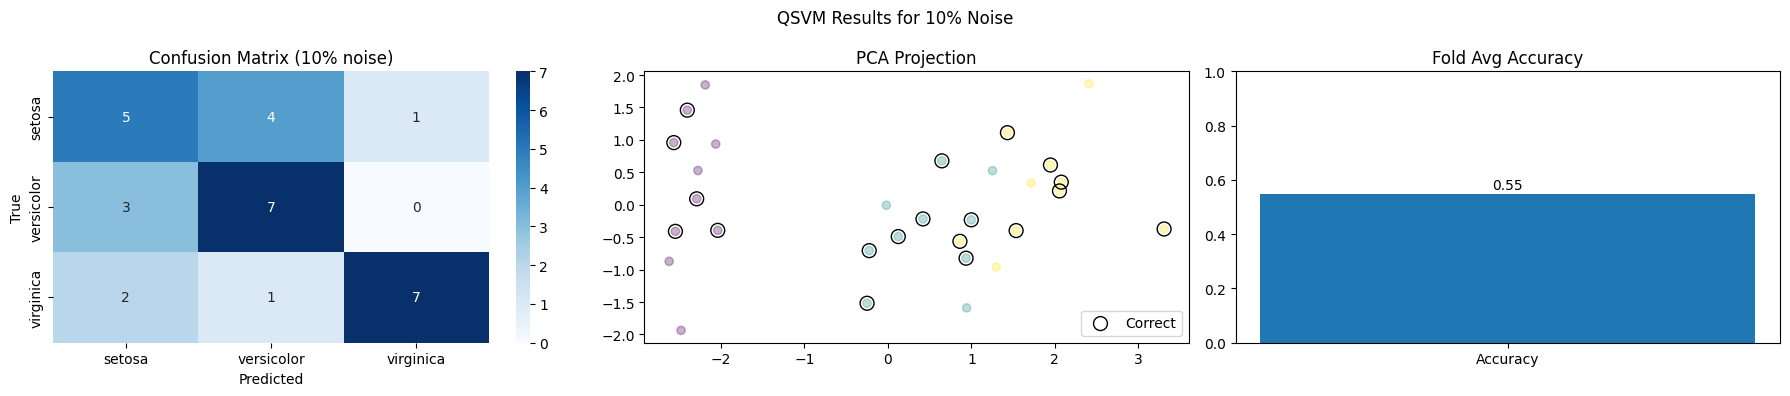

Processing 20% noise...


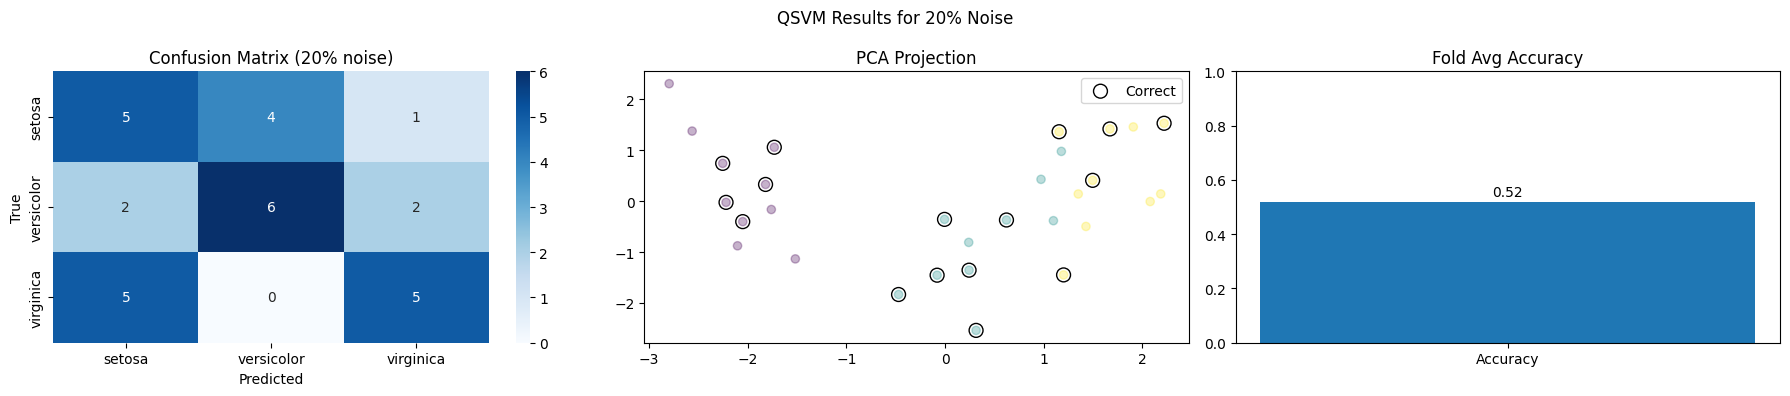

Processing 30% noise...


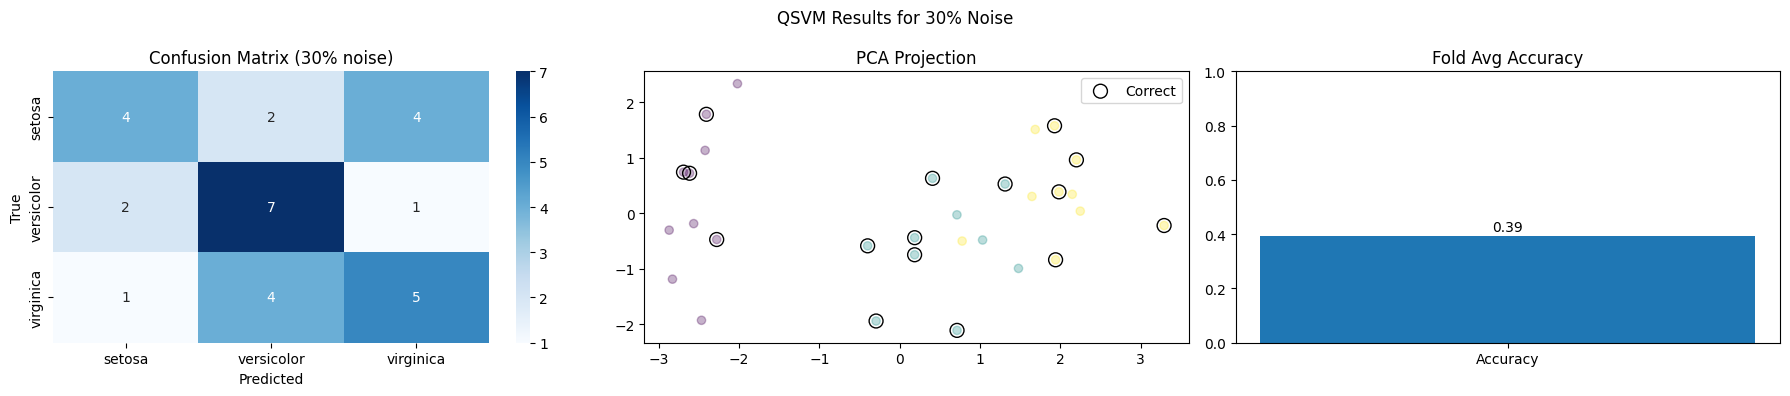

Processing 40% noise...


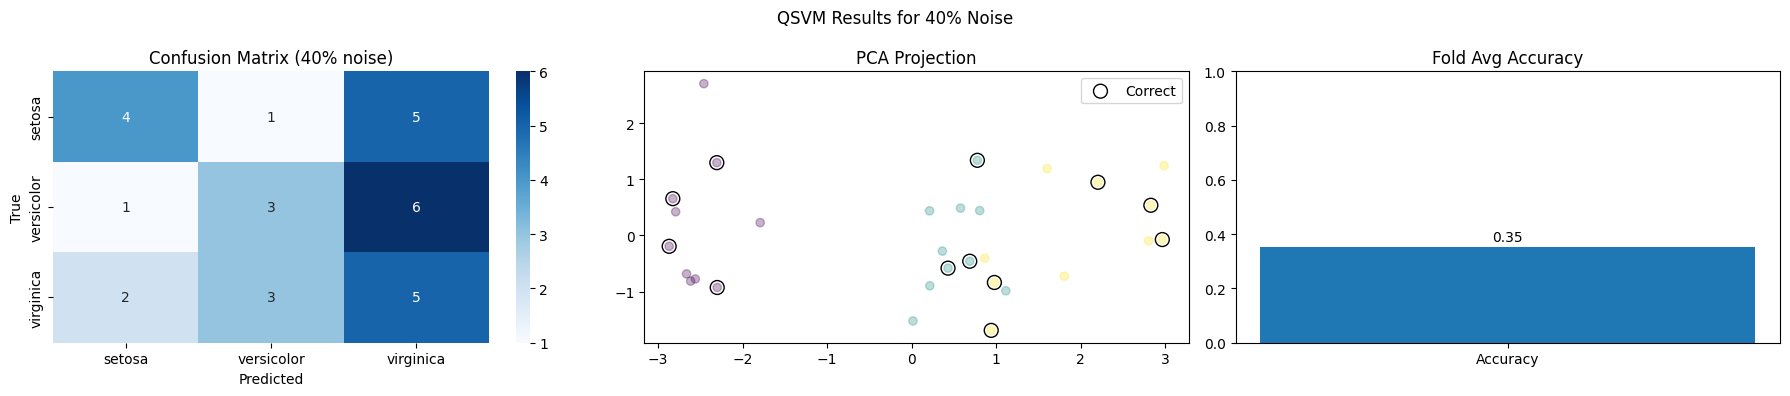

Processing 50% noise...


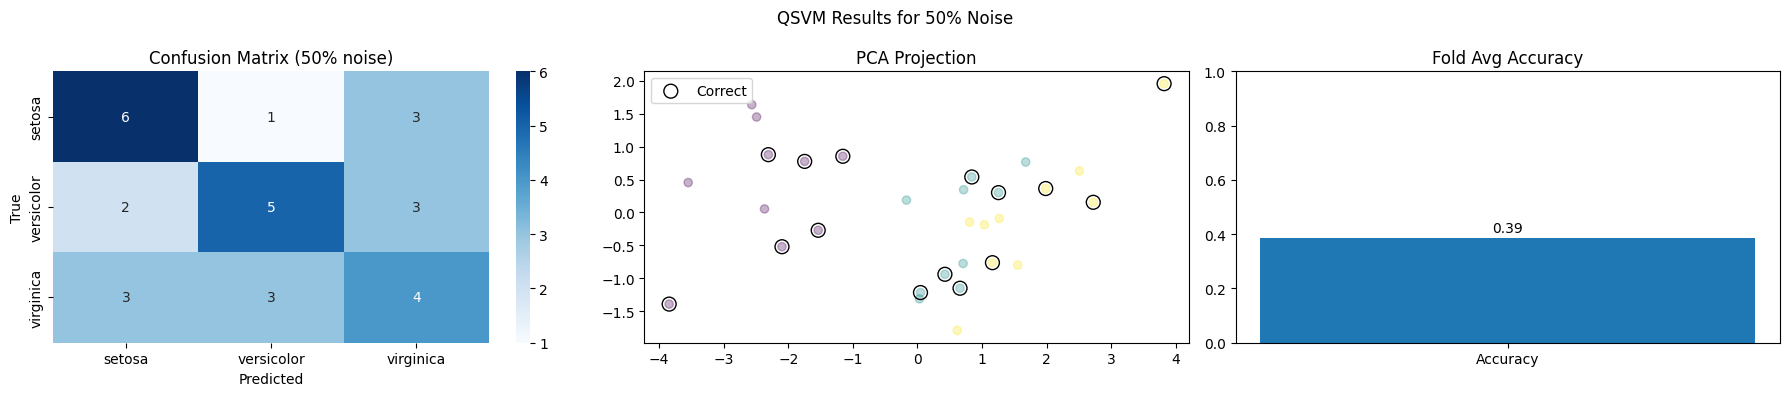

Processing 60% noise...


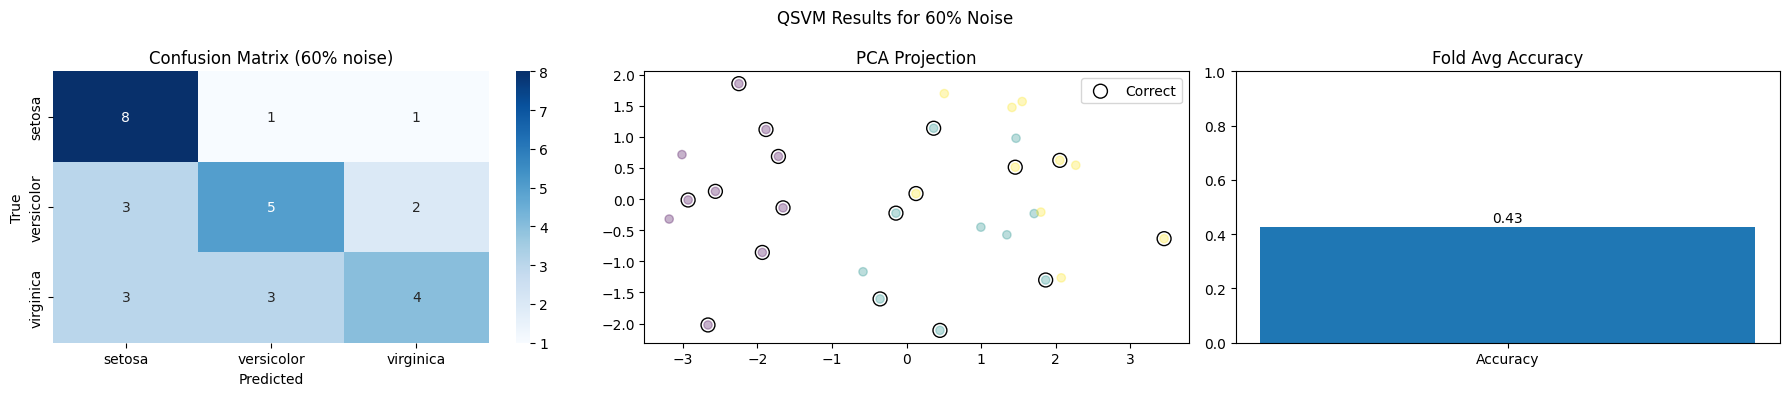

Processing 70% noise...


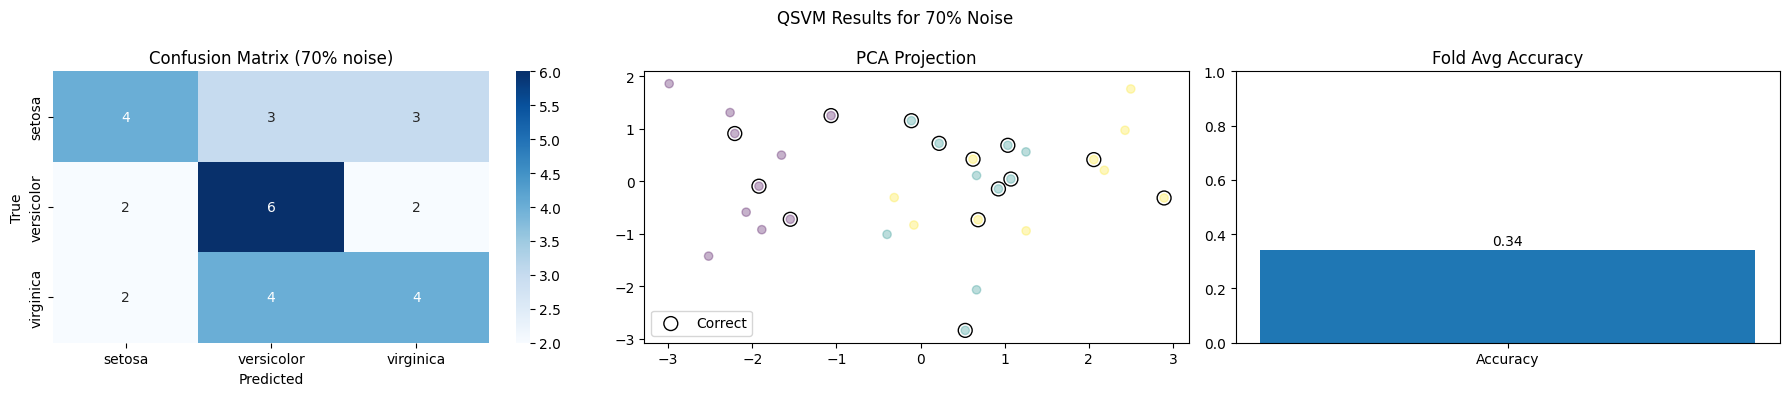

Processing 80% noise...


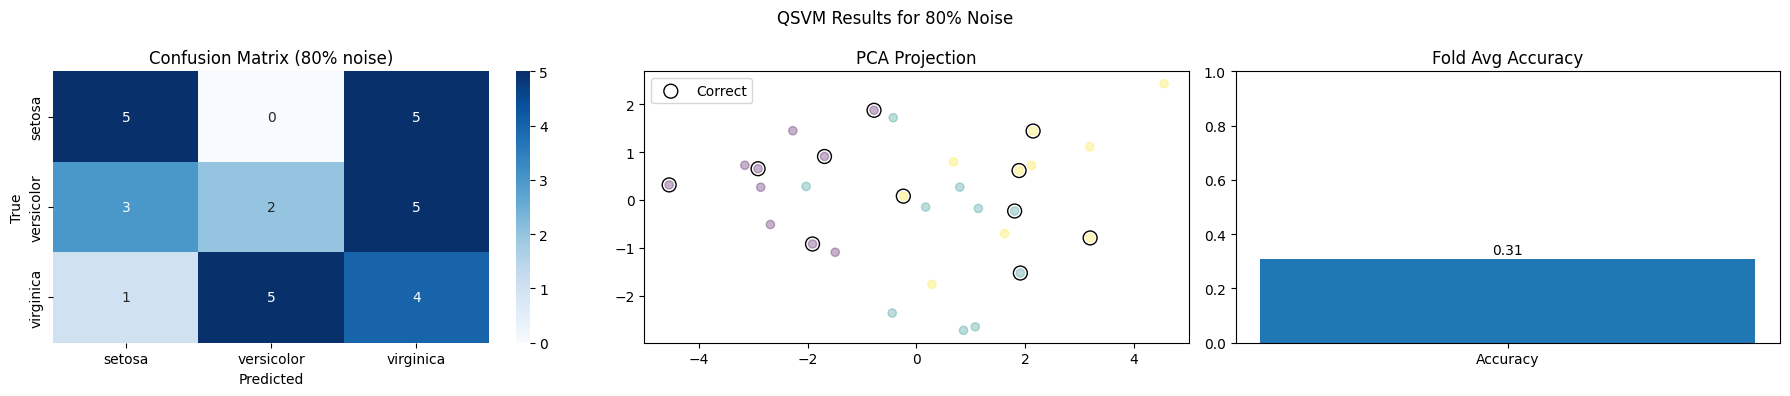

Processing 90% noise...


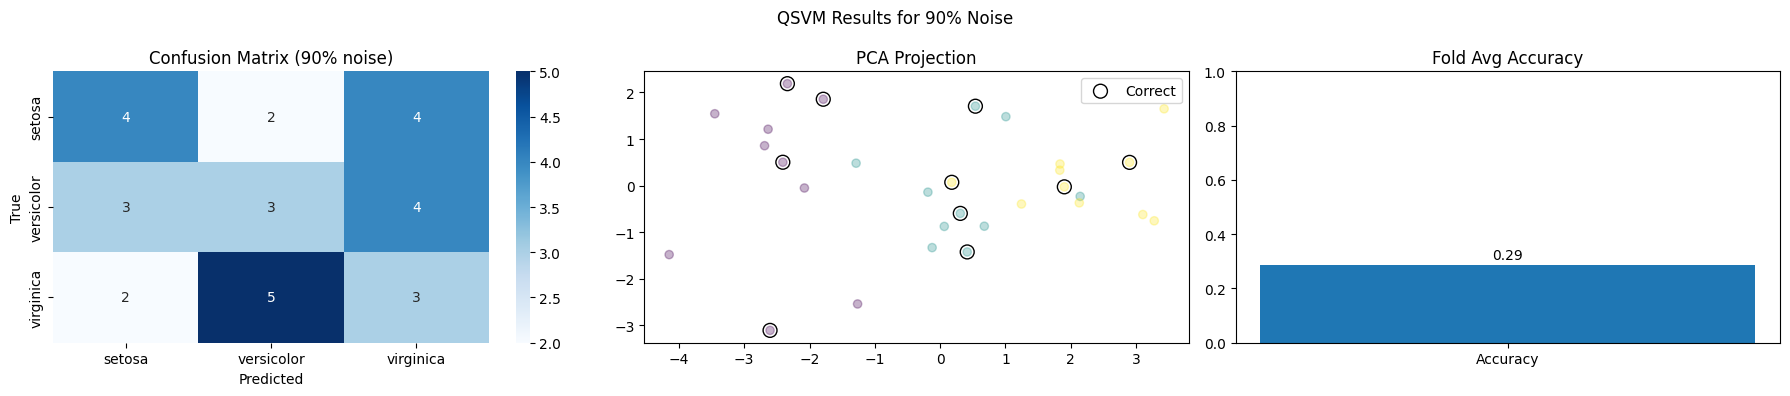

Processing 100% noise...


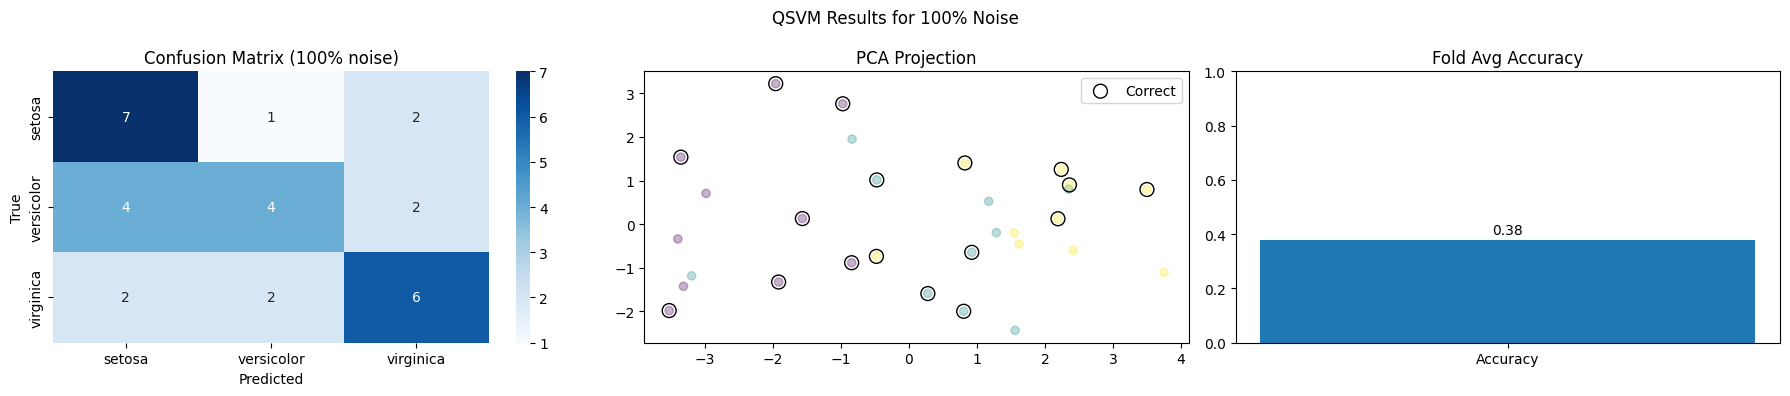

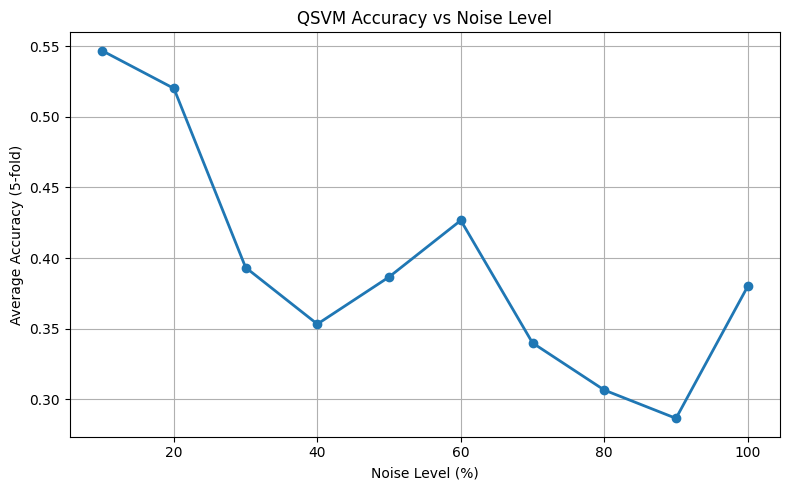

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.utils import QuantumInstance

# Configuration
np.random.seed(0)
noise_levels = np.arange(0.1, 1.1, 0.1)
backend = BasicAer.get_backend("statevector_simulator")
feature_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, shots=1024, seed_simulator=42, seed_transpiler=42)

# Load and scale the data
iris = load_iris()
X_base = StandardScaler().fit_transform(iris.data)
y = iris.target
target_names = iris.target_names
overall_accuracies = []

# Loop through noise levels
for noise_factor in noise_levels:
    print(f"Processing {int(noise_factor * 100)}% noise...")
    noise = np.random.normal(0, noise_factor * X_base.std(), X_base.shape)
    X_noisy = X_base + noise

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    accs = []
    best_cm = None
    best_preds = None
    best_true = None
    best_X_test = None

    for train_idx, test_idx in skf.split(X_noisy, y):
        X_train, y_train = X_noisy[train_idx], y[train_idx]
        X_test, y_test = X_noisy[test_idx], y[test_idx]

        # Quantum kernel and SVM
        qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)
        svc = SVC(kernel=qkernel.evaluate)
        svc.fit(X_train, y_train)

        y_pred = svc.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accs.append(acc)

        if acc == max(accs):
            best_cm = confusion_matrix(y_test, y_pred)
            best_preds = y_pred
            best_true = y_test
            best_X_test = X_test

    avg_acc = np.mean(accs)
    overall_accuracies.append(avg_acc)

    # Plot results for this noise level
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # Confusion Matrix
    sns.heatmap(best_cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=target_names, yticklabels=target_names, ax=axs[0])
    axs[0].set_title(f"Confusion Matrix ({int(noise_factor*100)}% noise)")
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("True")

    # PCA Projection
    X_proj = PCA(n_components=2).fit_transform(best_X_test)
    correct = (best_preds == best_true)
    axs[1].scatter(X_proj[:, 0], X_proj[:, 1], c=best_true, cmap="viridis", alpha=0.3)
    axs[1].scatter(X_proj[correct, 0], X_proj[correct, 1],
                   edgecolors='black', facecolors='none', s=100, label='Correct')
    axs[1].legend()
    axs[1].set_title("PCA Projection")

    # Accuracy bar
    axs[2].bar(["Accuracy"], [avg_acc])
    axs[2].set_ylim(0, 1)
    axs[2].set_title("Fold Avg Accuracy")
    axs[2].text(0, avg_acc + 0.02, f"{avg_acc:.2f}", ha='center')

    plt.suptitle(f"QSVM Results for {int(noise_factor * 100)}% Noise")
    plt.tight_layout()
    plt.show()

# Final accuracy vs noise plot
plt.figure(figsize=(8, 5))
plt.plot(noise_levels * 100, overall_accuracies, marker='o', linewidth=2)
plt.title("QSVM Accuracy vs Noise Level")
plt.xlabel("Noise Level (%)")
plt.ylabel("Average Accuracy (5-fold)")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\SANDEEP SAHU\AppData\Local\Temp\ipykernel_9448\3410064063.py:81: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(BasicAer.get_backend("statevector_simulator"), shots=1024, seed_simulator=42)



=== 10% NOISE ===


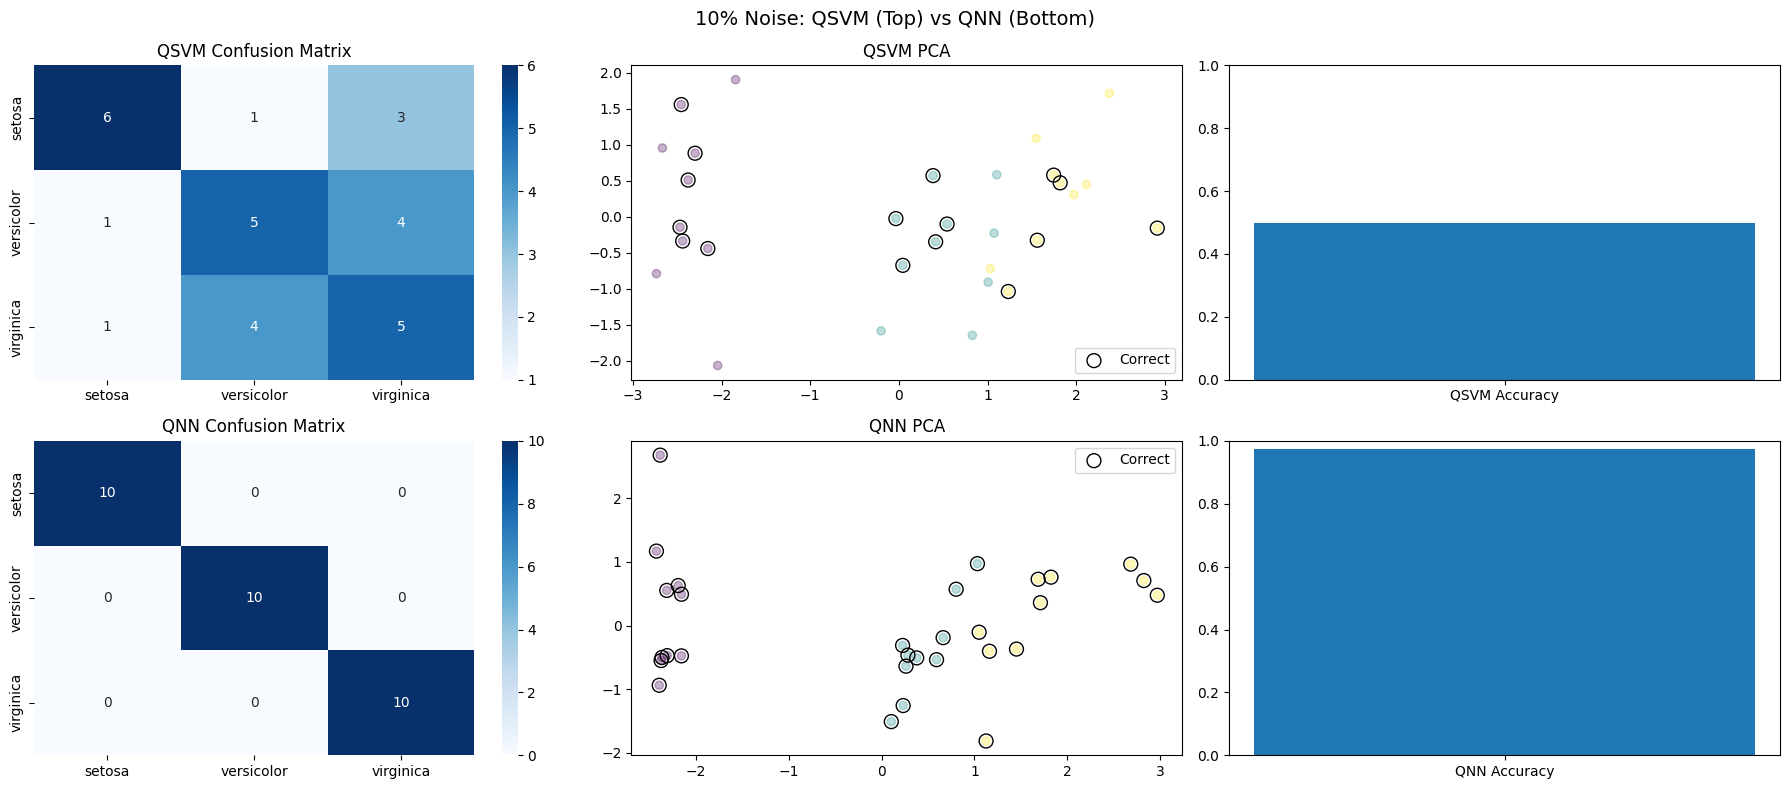


=== 20% NOISE ===


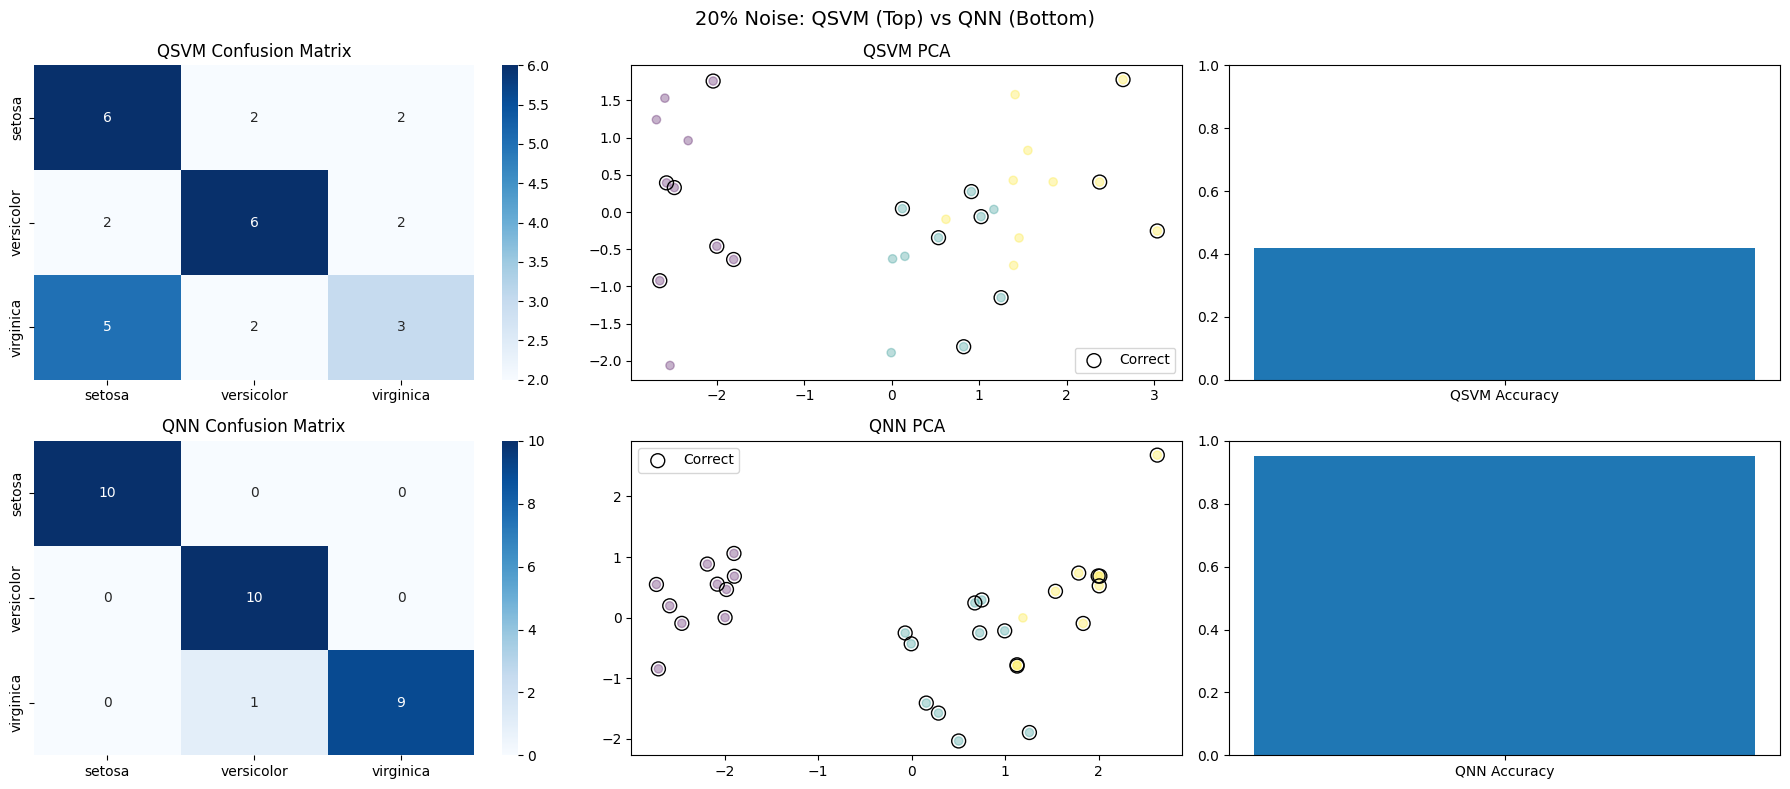


=== 30% NOISE ===


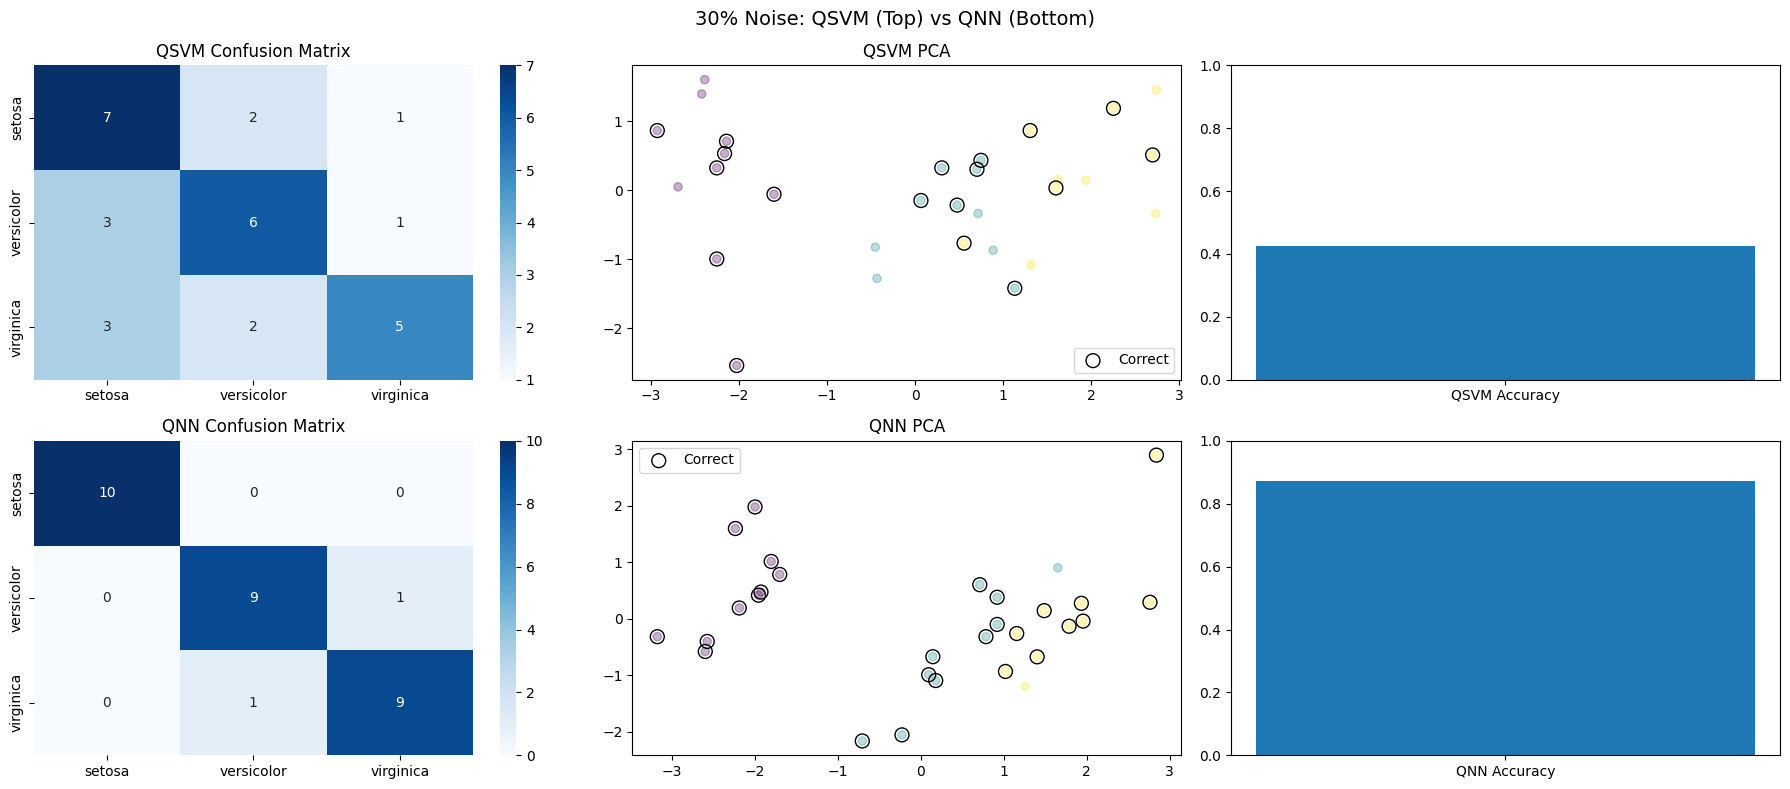


=== 40% NOISE ===


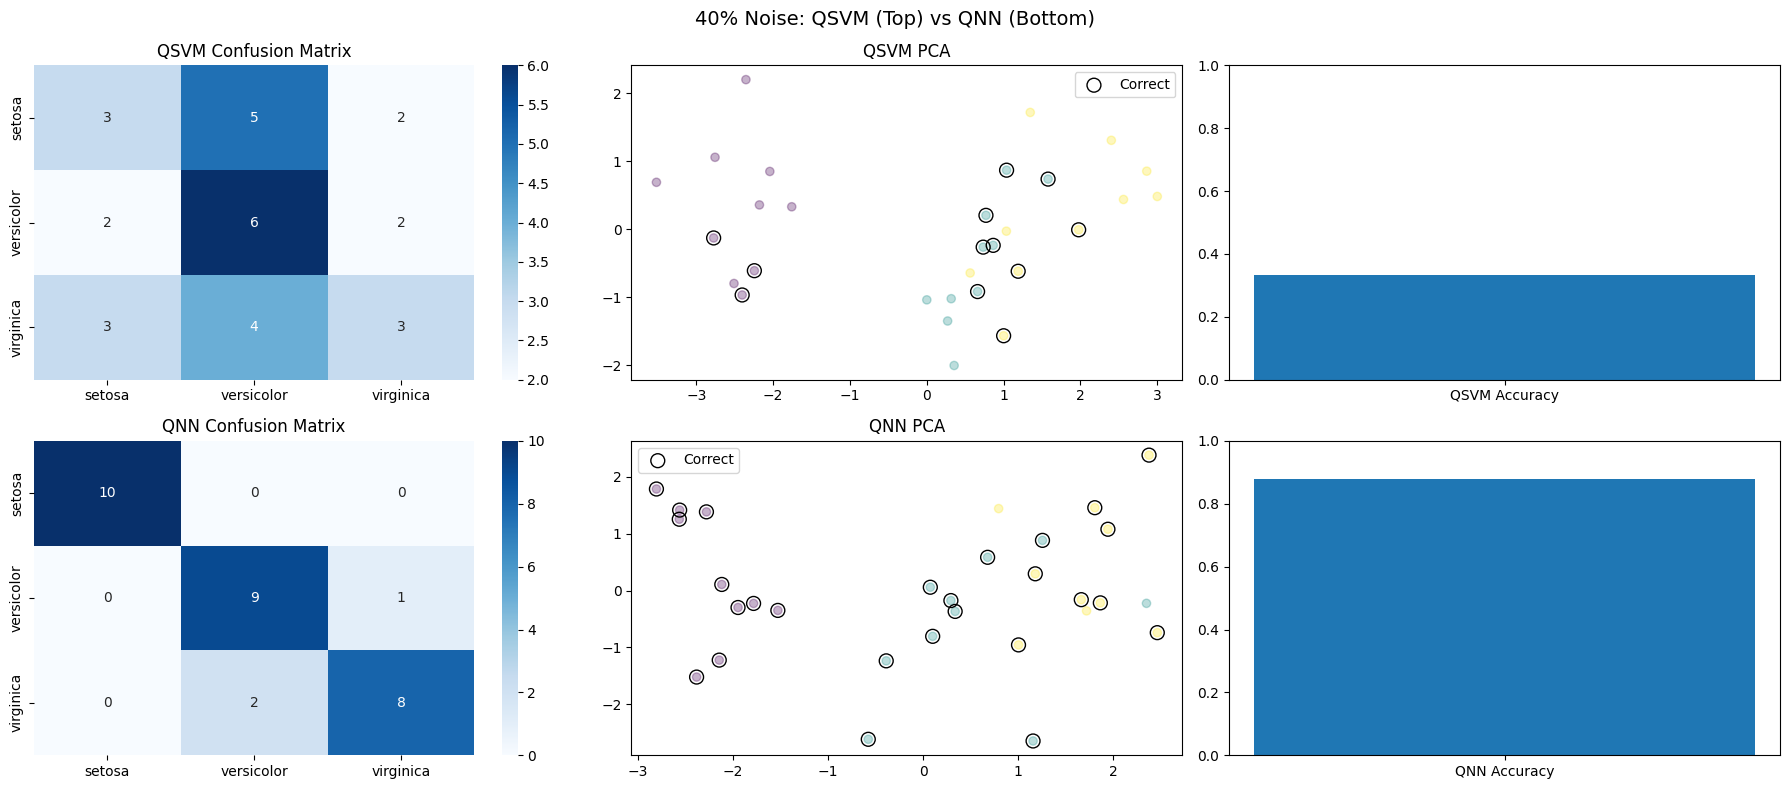


=== 50% NOISE ===


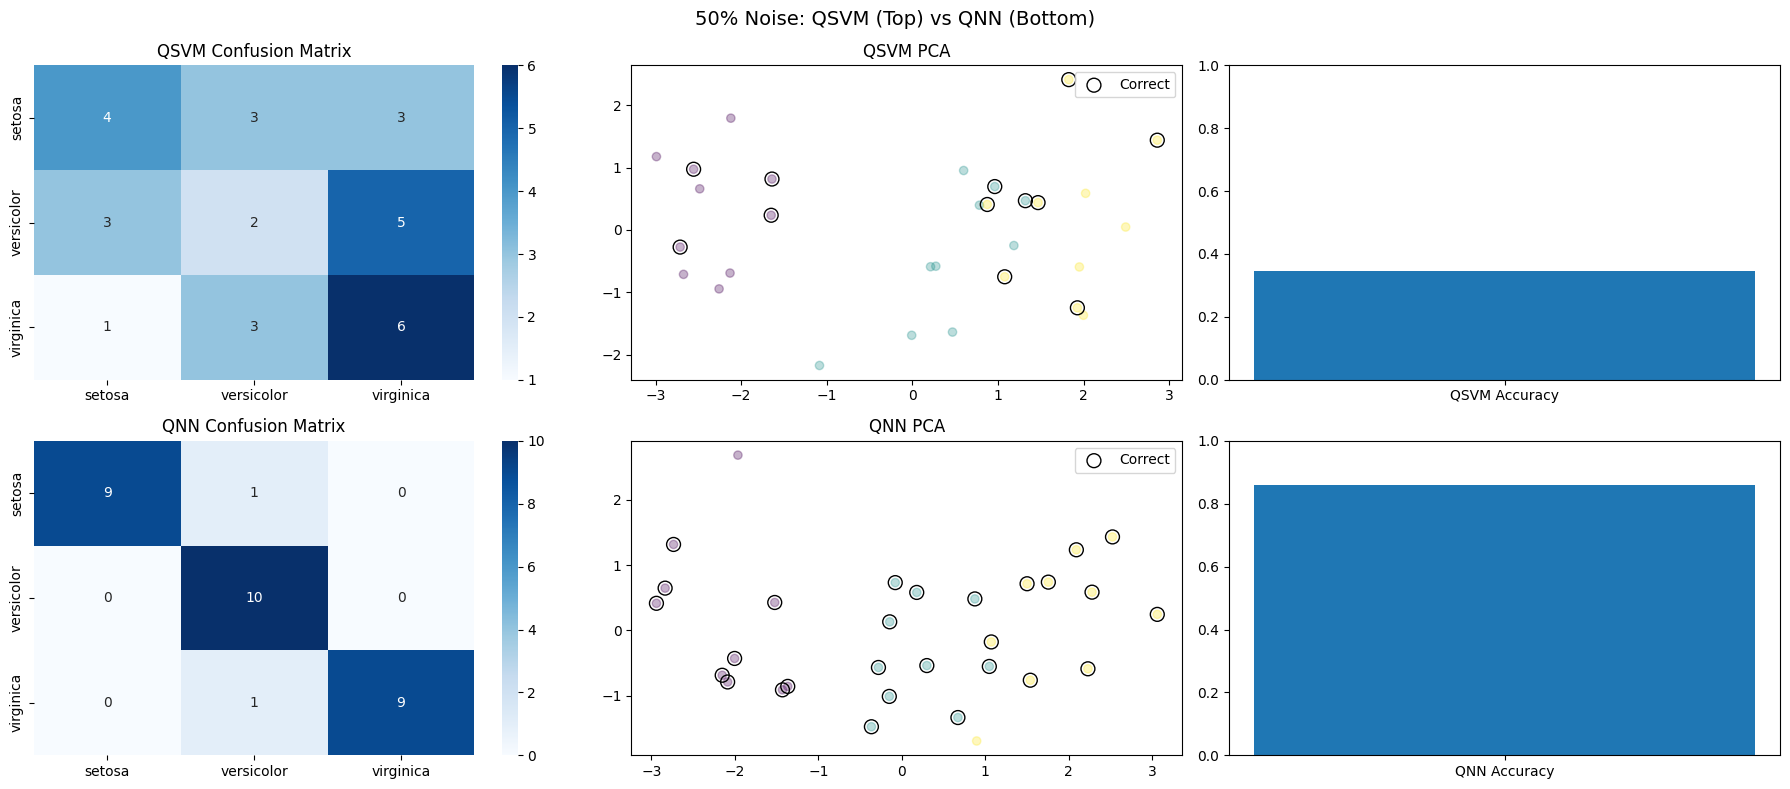


=== 60% NOISE ===


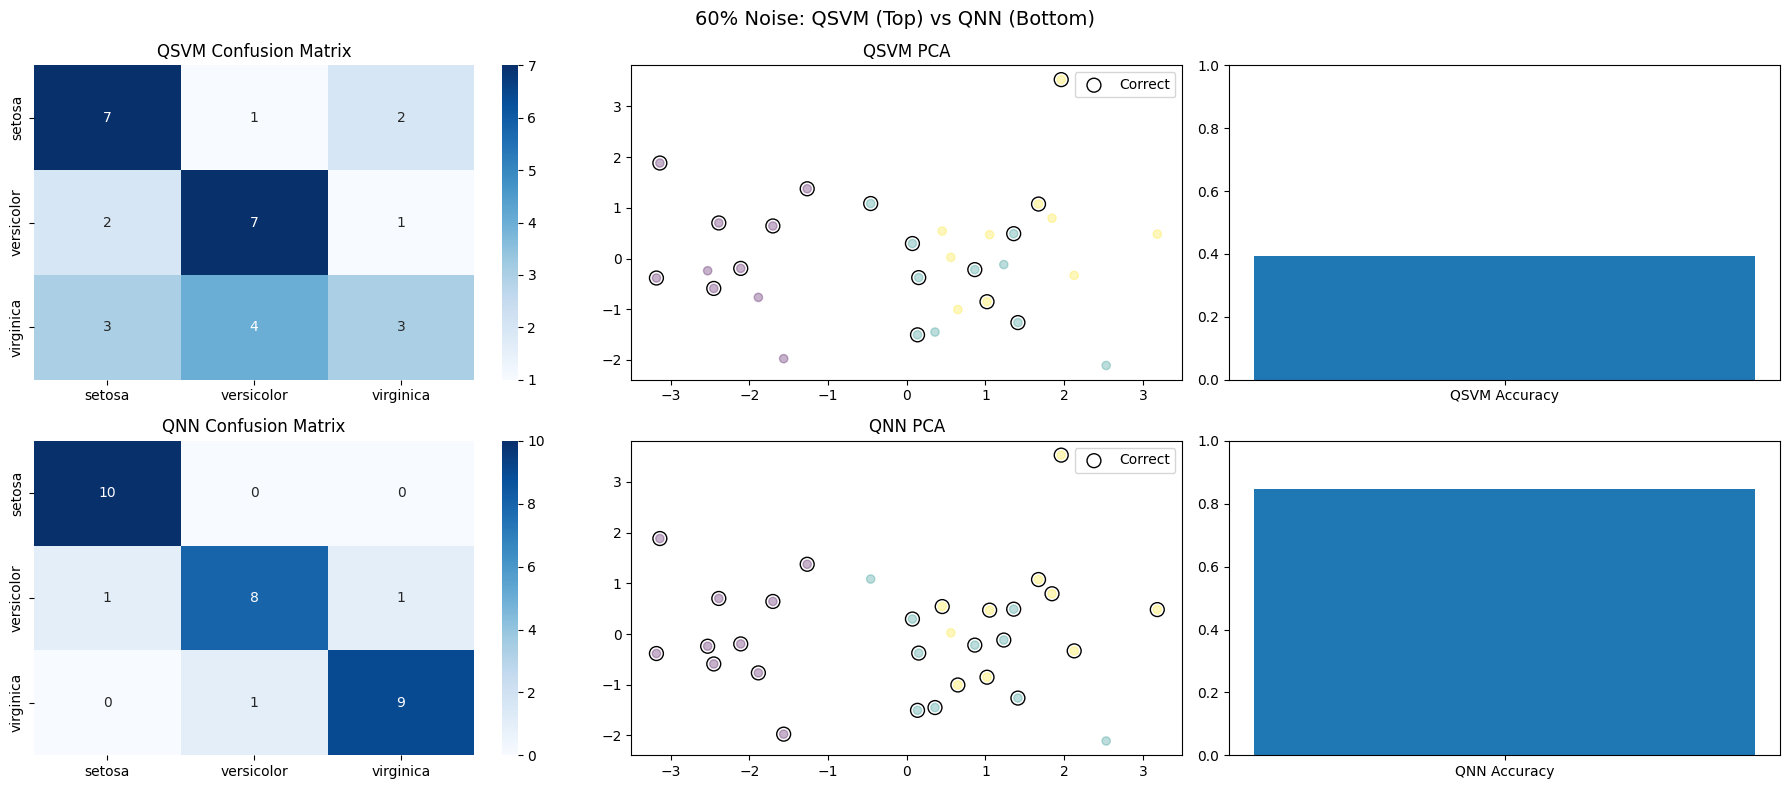


=== 70% NOISE ===


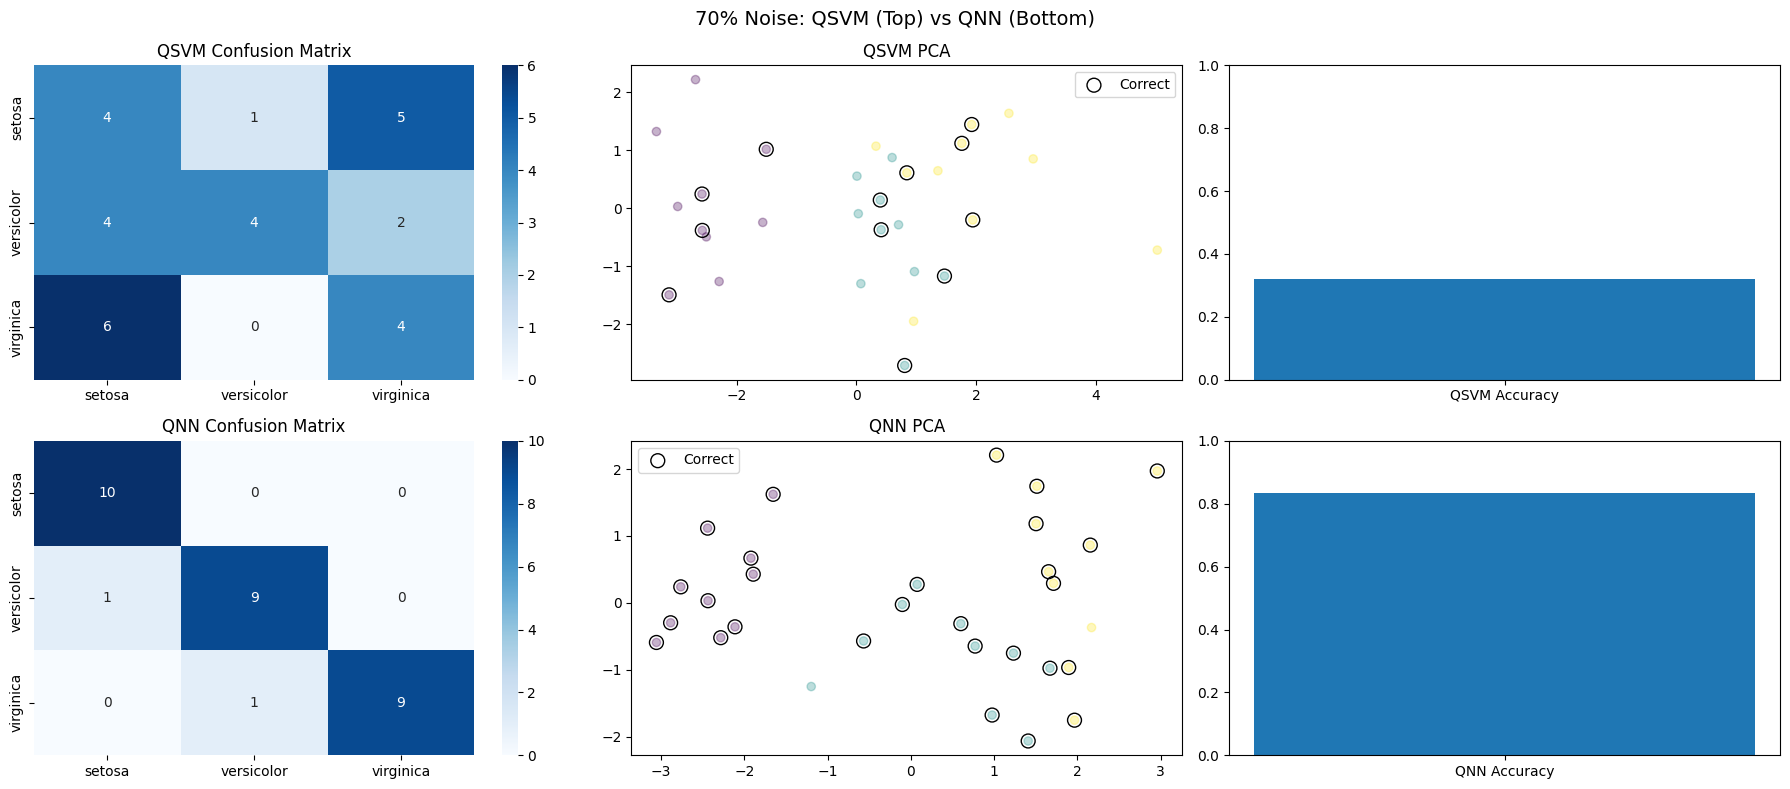


=== 80% NOISE ===


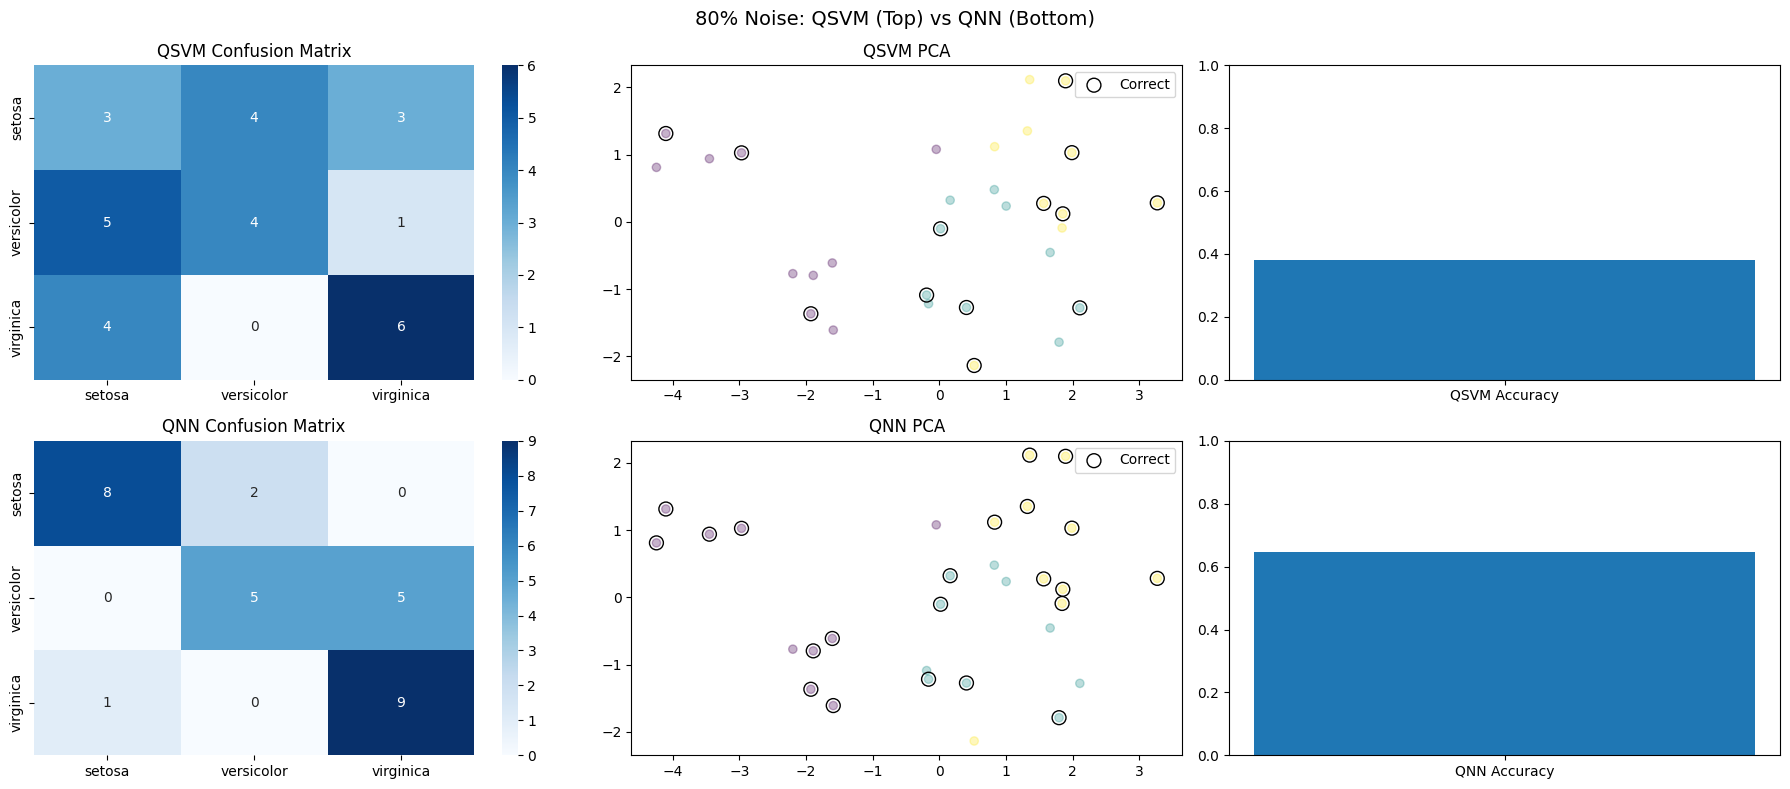


=== 90% NOISE ===


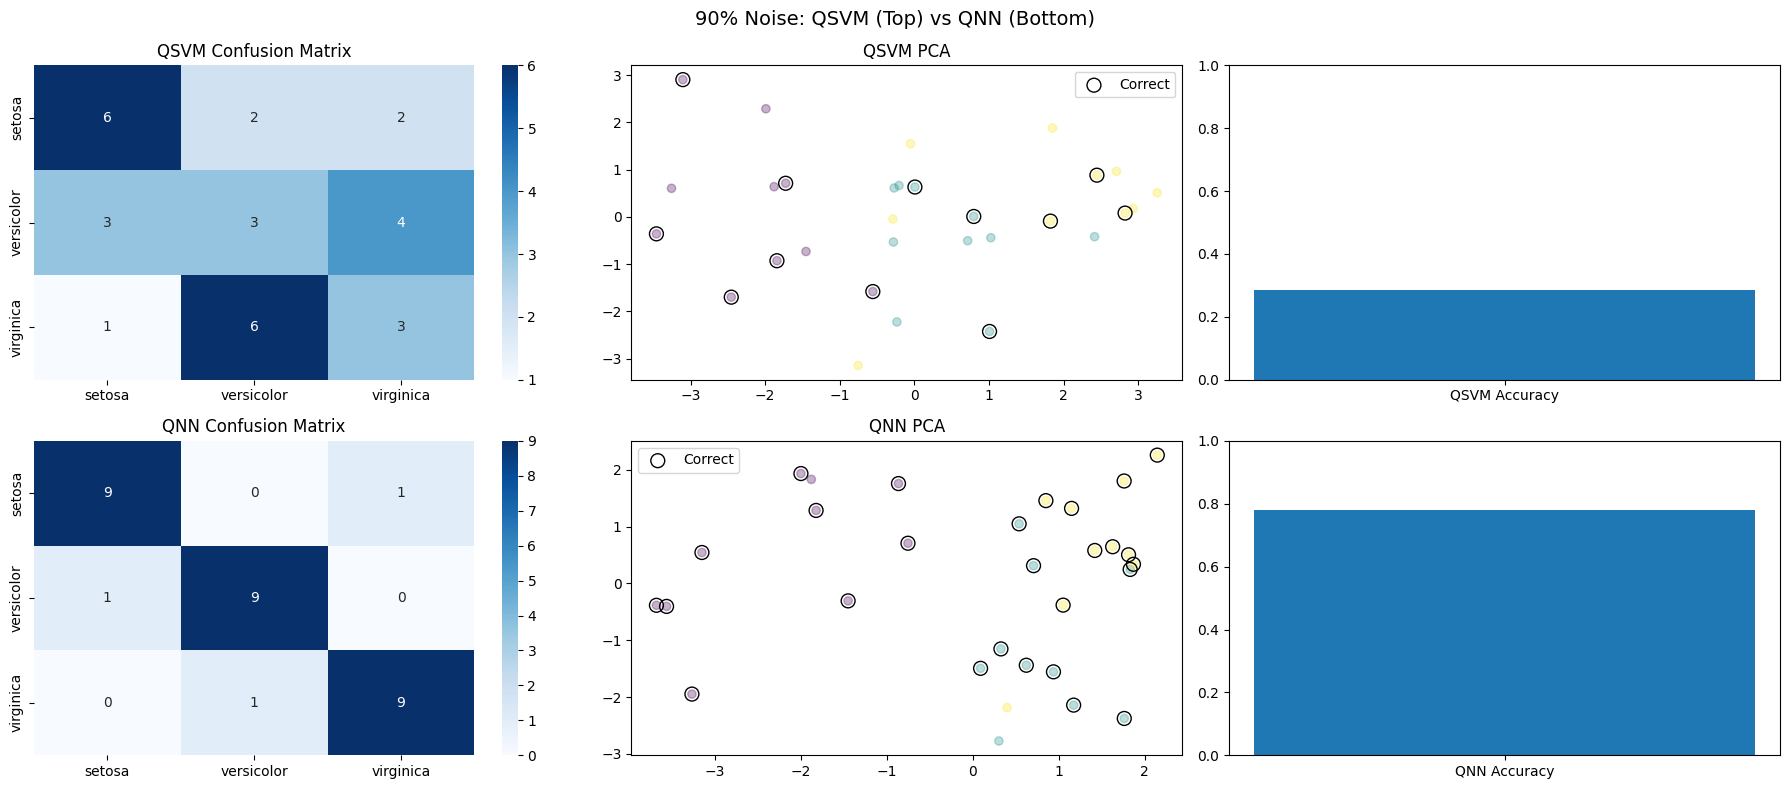


=== 100% NOISE ===


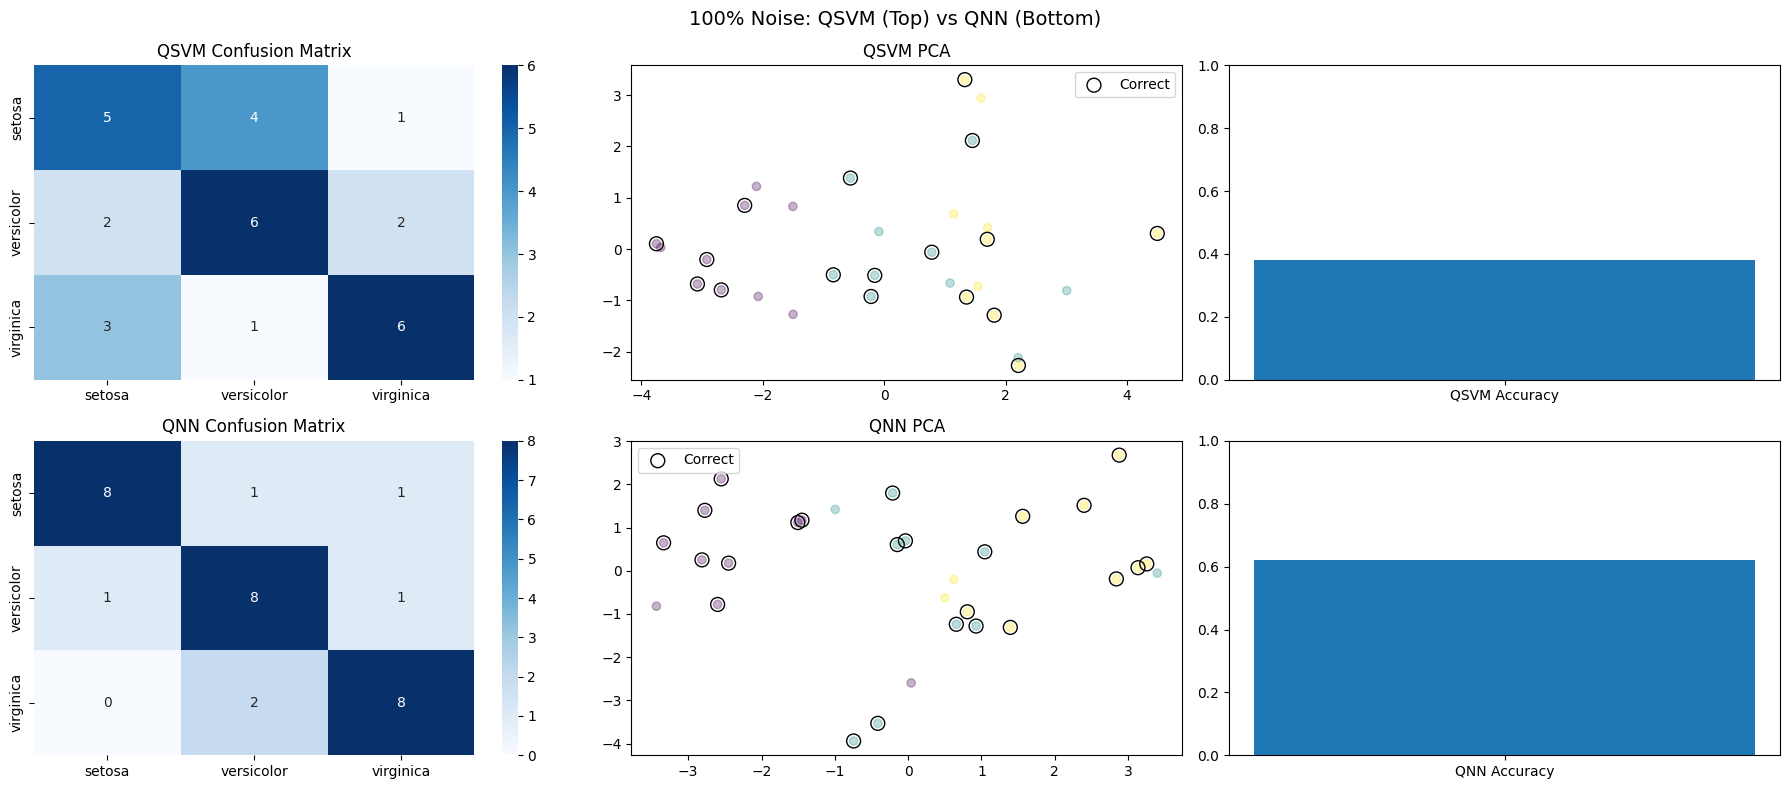

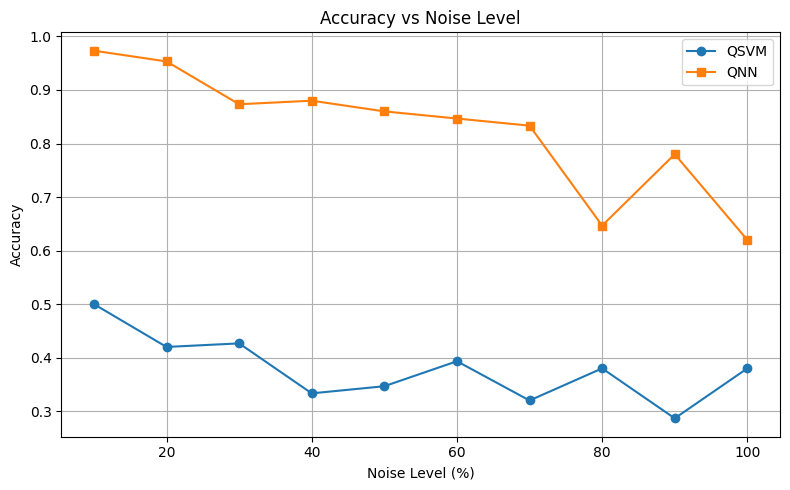

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel

import pennylane as qml

# Seed
np.random.seed(0)
torch.manual_seed(0)

# Data
iris = load_iris()
X_base = StandardScaler().fit_transform(iris.data)
y = iris.target
target_names = iris.target_names
noise_levels = np.arange(0.1, 1.1, 0.1)

# QNN config
n_qubits = 4
n_classes = 3
qml_dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(qml_dev, interface="torch")
def qnn_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QNNLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_layer = qml.qnn.TorchLayer(qnn_circuit, {"weights": (3, n_qubits, 3)})

    def forward(self, x):
        return self.q_layer(x)

class HybridQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qnn = QNNLayer()
        self.fc = nn.Linear(n_qubits, n_classes)

    def forward(self, x):
        return self.fc(self.qnn(x))

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.best_model = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# QSVM config
feature_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement="full")
quantum_instance = QuantumInstance(BasicAer.get_backend("statevector_simulator"), shots=1024, seed_simulator=42)

qnn_accs = []
qsvm_accs = []

for noise_factor in noise_levels:
    print(f"\n=== {int(noise_factor * 100)}% NOISE ===")
    X_noisy = X_base + np.random.normal(0, noise_factor * X_base.std(), X_base.shape)

    # ========== QSVM ==========
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    accs_qsvm = []
    best_cm_qsvm, best_X_qsvm, best_pred_qsvm, best_true_qsvm = None, None, None, None

    for train_idx, test_idx in skf.split(X_noisy, y):
        X_train, y_train = X_noisy[train_idx], y[train_idx]
        X_test, y_test = X_noisy[test_idx], y[test_idx]
        qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)
        svc = SVC(kernel=qkernel.evaluate)
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accs_qsvm.append(acc)
        if acc == max(accs_qsvm):
            best_cm_qsvm = confusion_matrix(y_test, y_pred)
            best_X_qsvm = X_test
            best_pred_qsvm = y_pred
            best_true_qsvm = y_test

    avg_qsvm = np.mean(accs_qsvm)
    qsvm_accs.append(avg_qsvm)

    # ========== QNN ==========
    accs_qnn = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    best_cm_qnn, best_X_qnn, best_pred_qnn, best_true_qnn = None, None, None, None

    for train_idx, test_idx in skf.split(X_noisy, y):
        X_train, y_train = X_noisy[train_idx], y[train_idx]
        X_test, y_test = X_noisy[test_idx], y[test_idx]
        train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                torch.tensor(y_train, dtype=torch.long)),
                                  batch_size=16, shuffle=True)

        model = HybridQNN()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()
        early_stopper = EarlyStopping(patience=10)

        for epoch in range(100):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = model(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()

            val_tensor = torch.tensor(X_test, dtype=torch.float32)
            val_labels = torch.tensor(y_test, dtype=torch.long)
            model.eval()
            with torch.no_grad():
                val_loss = criterion(model(val_tensor), val_labels).item()
            early_stopper(val_loss, model)
            if early_stopper.early_stop:
                break

        model.load_state_dict(early_stopper.best_model)
        model.eval()
        with torch.no_grad():
            preds = model(torch.tensor(X_test, dtype=torch.float32)).argmax(1).numpy()
        acc = accuracy_score(y_test, preds)
        accs_qnn.append(acc)
        if acc == max(accs_qnn):
            best_cm_qnn = confusion_matrix(y_test, preds)
            best_X_qnn = X_test
            best_pred_qnn = preds
            best_true_qnn = y_test

    avg_qnn = np.mean(accs_qnn)
    qnn_accs.append(avg_qnn)

    # ========== VISUALIZATION ==========
    fig, axs = plt.subplots(2, 3, figsize=(18, 8))
    fig.suptitle(f"{int(noise_factor * 100)}% Noise: QSVM (Top) vs QNN (Bottom)", fontsize=14)

    # QSVM
    sns.heatmap(best_cm_qsvm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names, ax=axs[0, 0])
    axs[0, 0].set_title("QSVM Confusion Matrix")
    pca_qsvm = PCA(n_components=2).fit_transform(best_X_qsvm)
    correct_qsvm = best_pred_qsvm == best_true_qsvm
    axs[0, 1].scatter(pca_qsvm[:, 0], pca_qsvm[:, 1], c=best_true_qsvm, cmap="viridis", alpha=0.3)
    axs[0, 1].scatter(pca_qsvm[correct_qsvm, 0], pca_qsvm[correct_qsvm, 1],
                      edgecolors='black', facecolors='none', s=100, label='Correct')
    axs[0, 1].legend(); axs[0, 1].set_title("QSVM PCA")
    axs[0, 2].bar(["QSVM Accuracy"], [avg_qsvm])
    axs[0, 2].set_ylim(0, 1)

    # QNN
    sns.heatmap(best_cm_qnn, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names, ax=axs[1, 0])
    axs[1, 0].set_title("QNN Confusion Matrix")
    pca_qnn = PCA(n_components=2).fit_transform(best_X_qnn)
    correct_qnn = best_pred_qnn == best_true_qnn
    axs[1, 1].scatter(pca_qnn[:, 0], pca_qnn[:, 1], c=best_true_qnn, cmap="viridis", alpha=0.3)
    axs[1, 1].scatter(pca_qnn[correct_qnn, 0], pca_qnn[correct_qnn, 1],
                      edgecolors='black', facecolors='none', s=100, label='Correct')
    axs[1, 1].legend(); axs[1, 1].set_title("QNN PCA")
    axs[1, 2].bar(["QNN Accuracy"], [avg_qnn])
    axs[1, 2].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

# Final comparison plot
plt.figure(figsize=(8, 5))
plt.plot(noise_levels * 100, qsvm_accs, marker='o', label="QSVM")
plt.plot(noise_levels * 100, qnn_accs, marker='s', label="QNN")
plt.title("Accuracy vs Noise Level")
plt.xlabel("Noise Level (%)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\SANDEEP SAHU\AppData\Local\Temp\ipykernel_9448\1319925387.py:76: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(BasicAer.get_backend("statevector_simulator"), shots=1024, seed_simulator=42)


Processing 10% noise


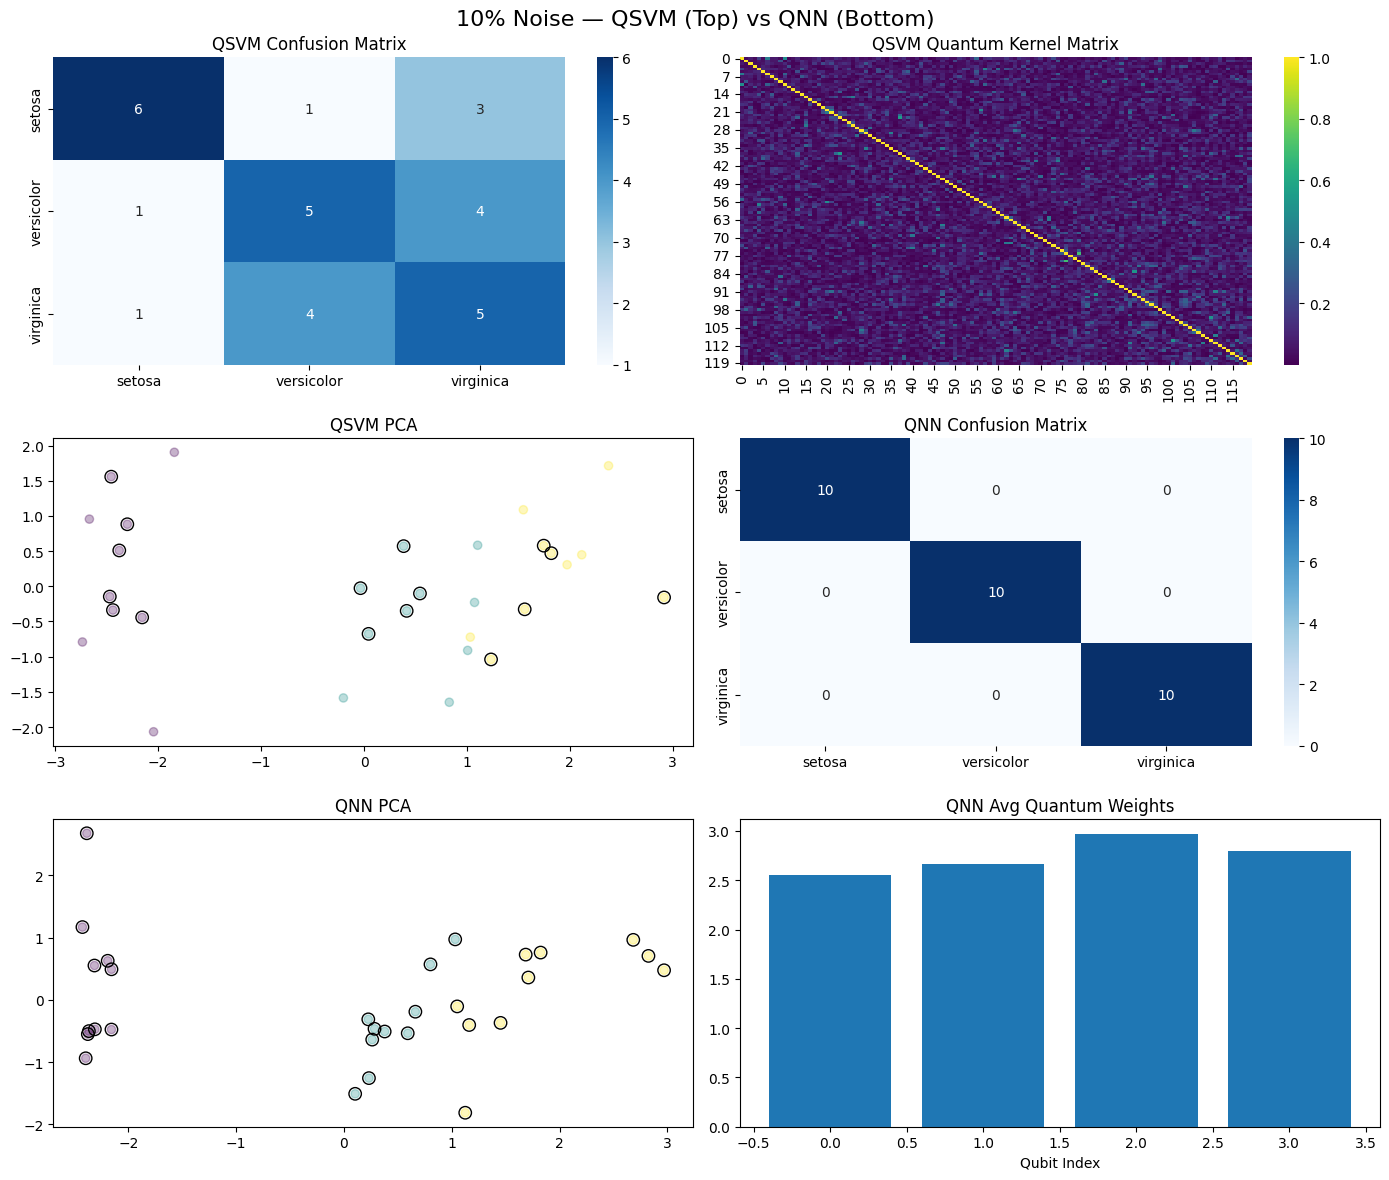

Processing 20% noise


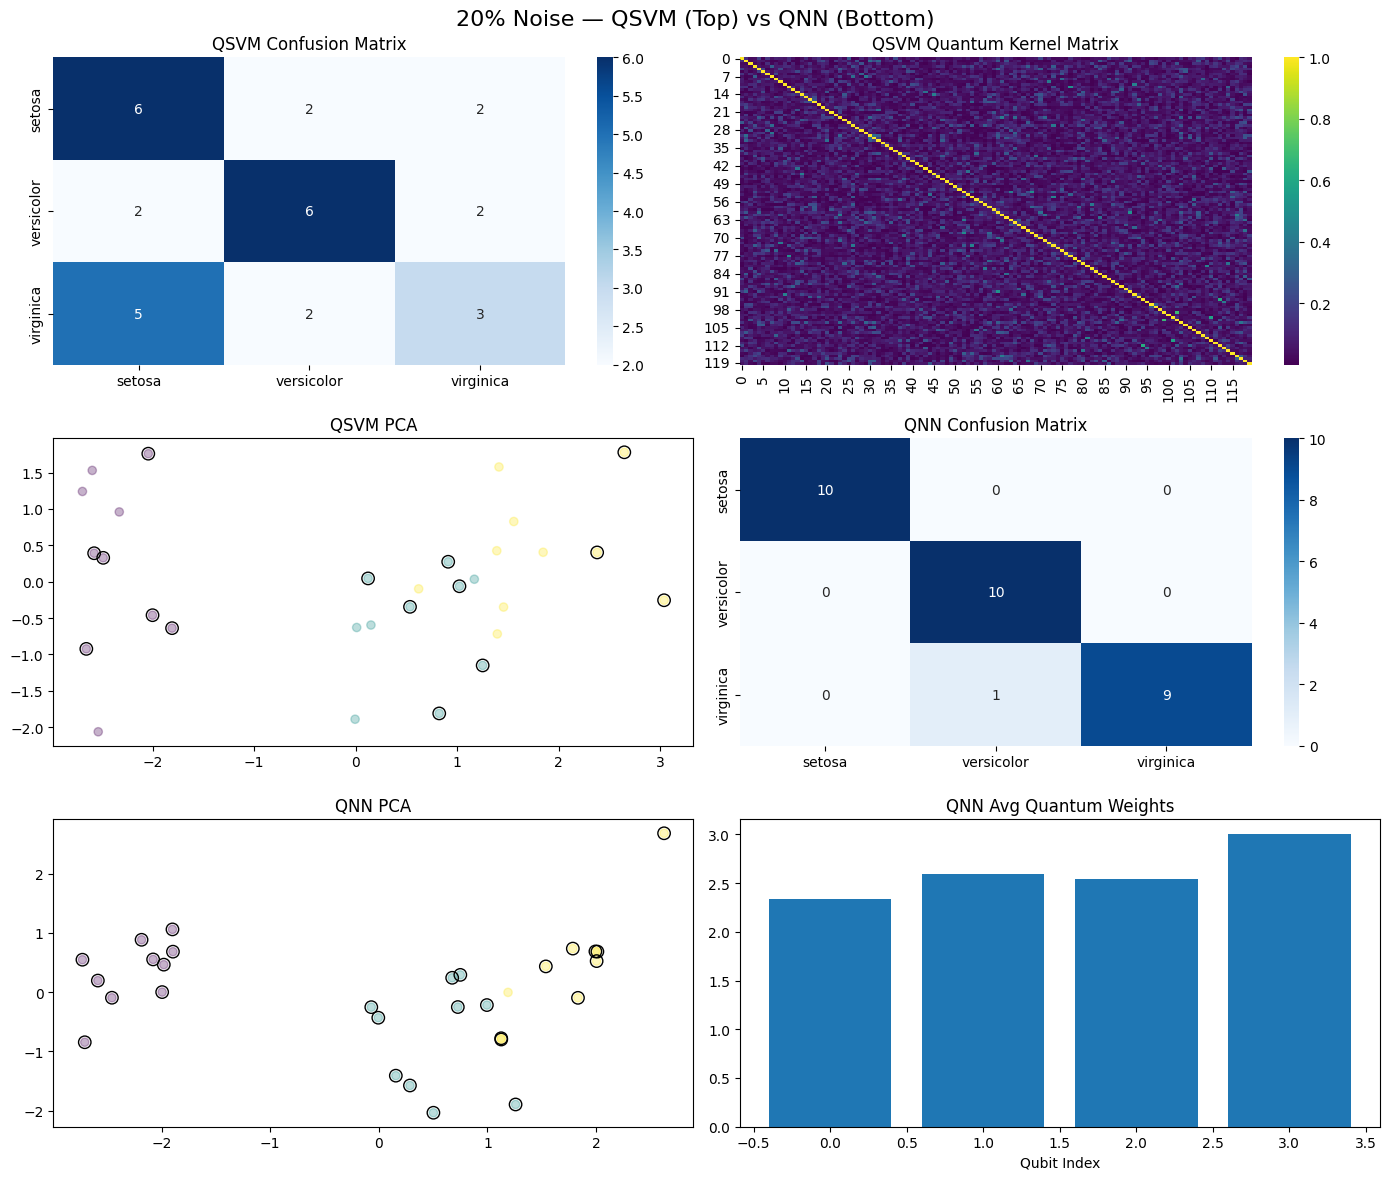

Processing 30% noise


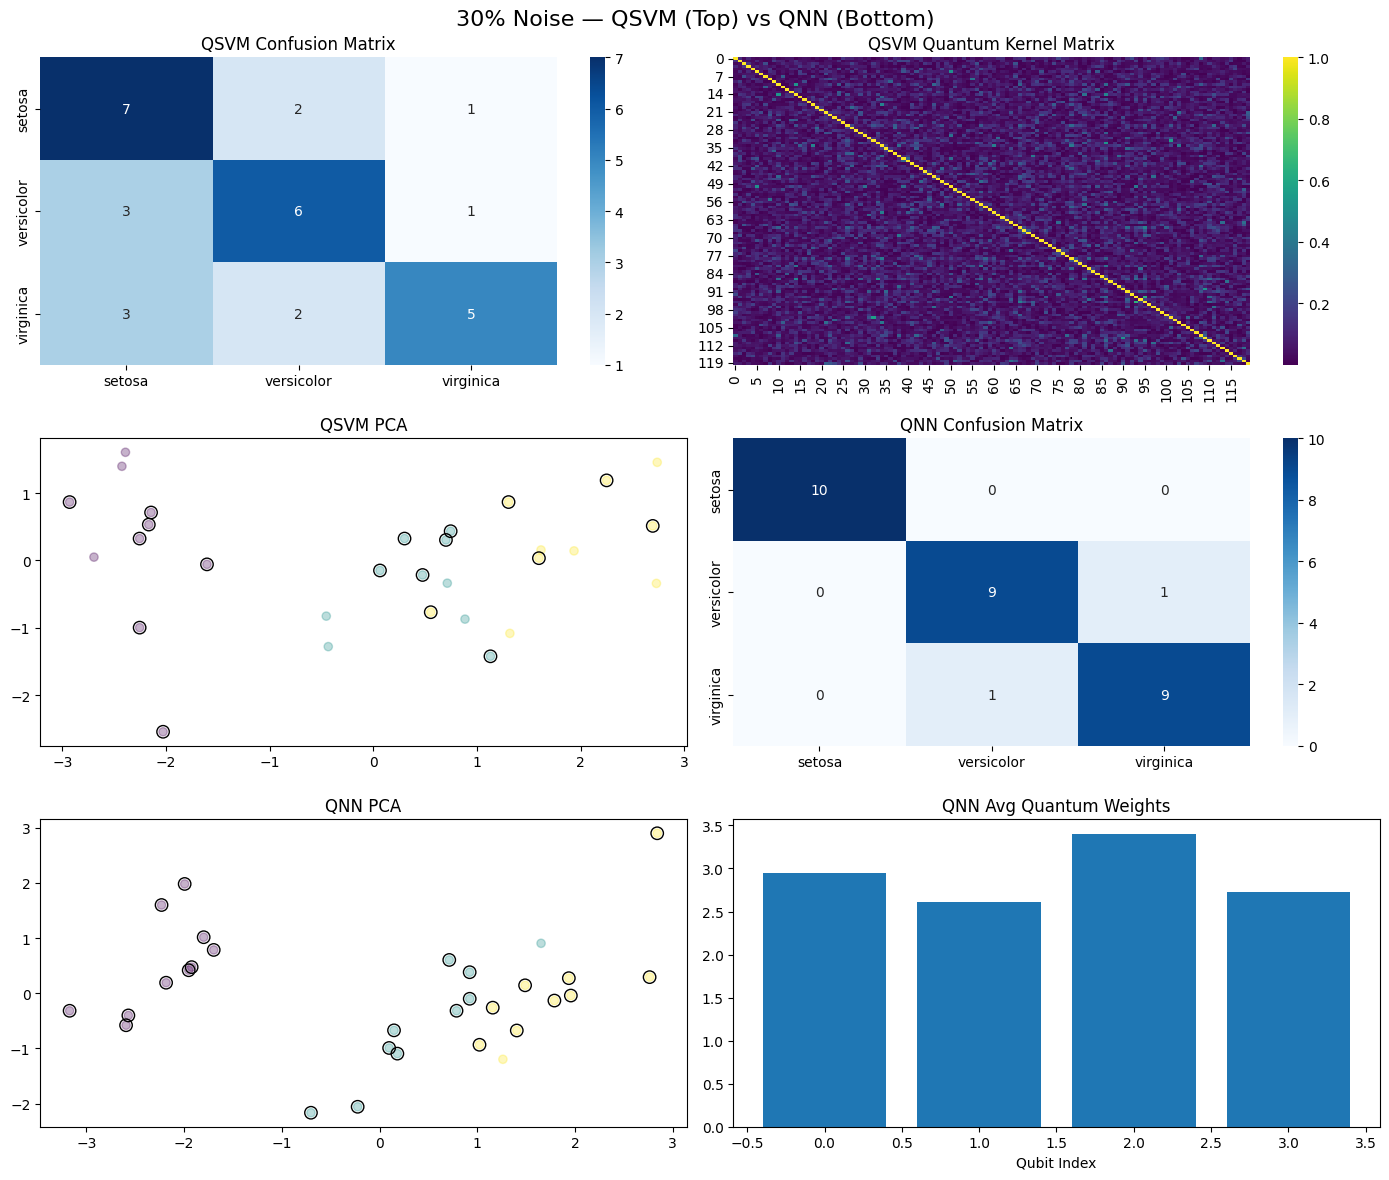

Processing 40% noise


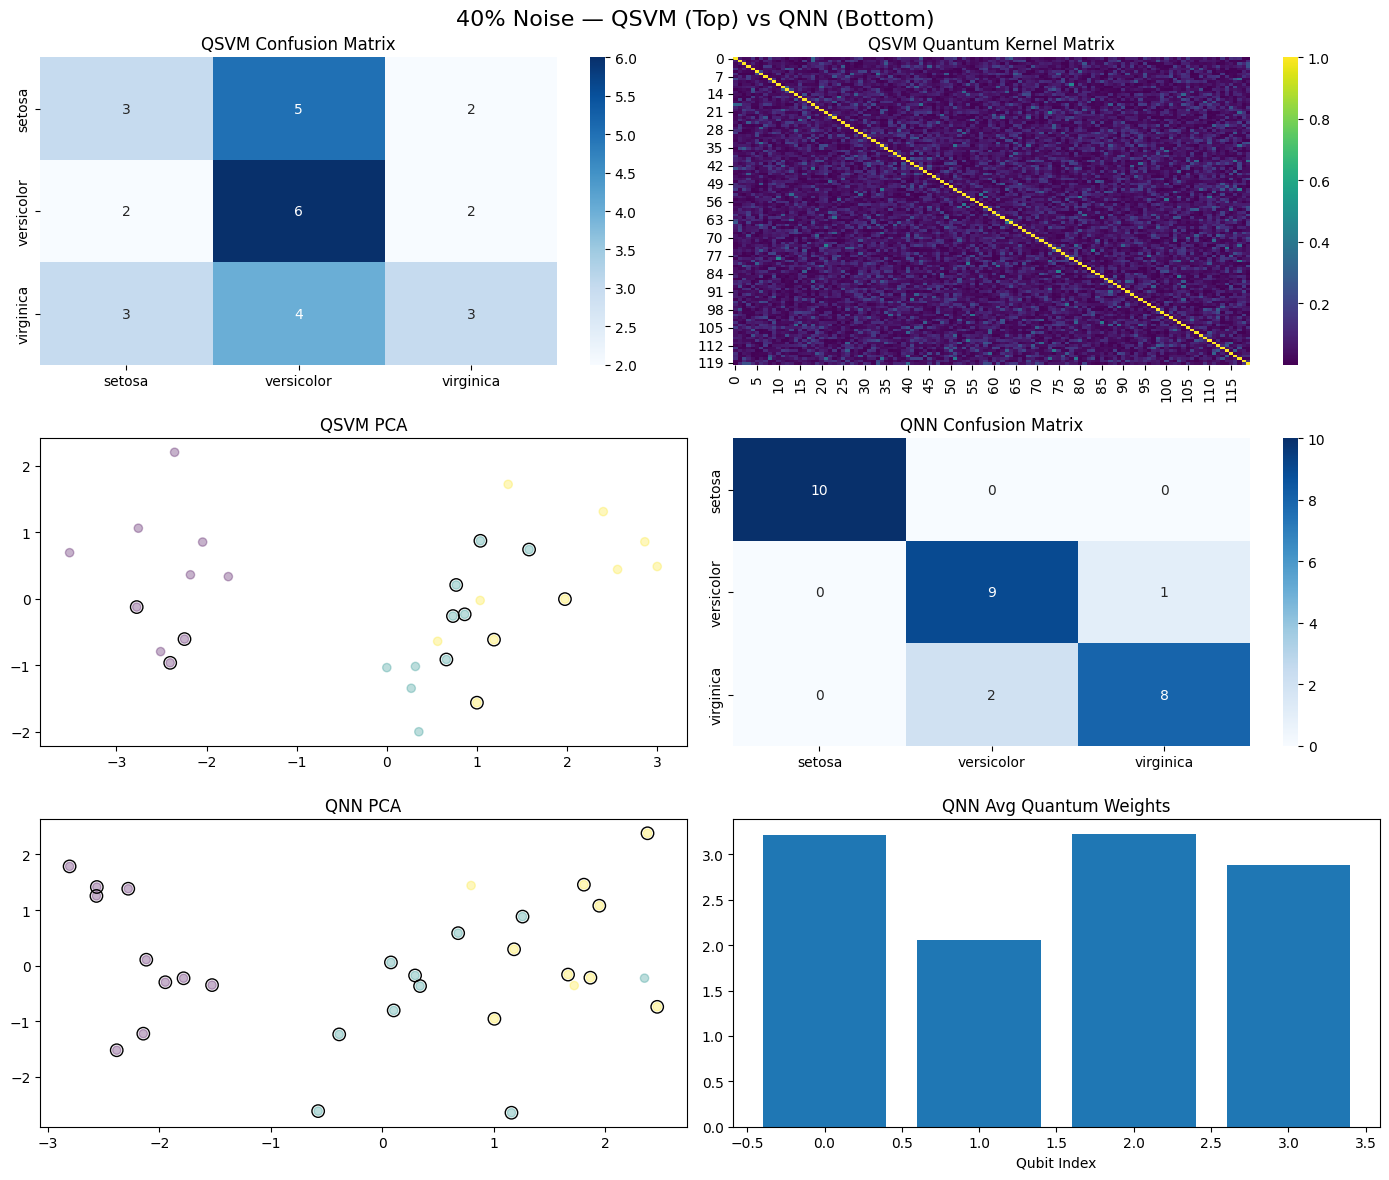

Processing 50% noise


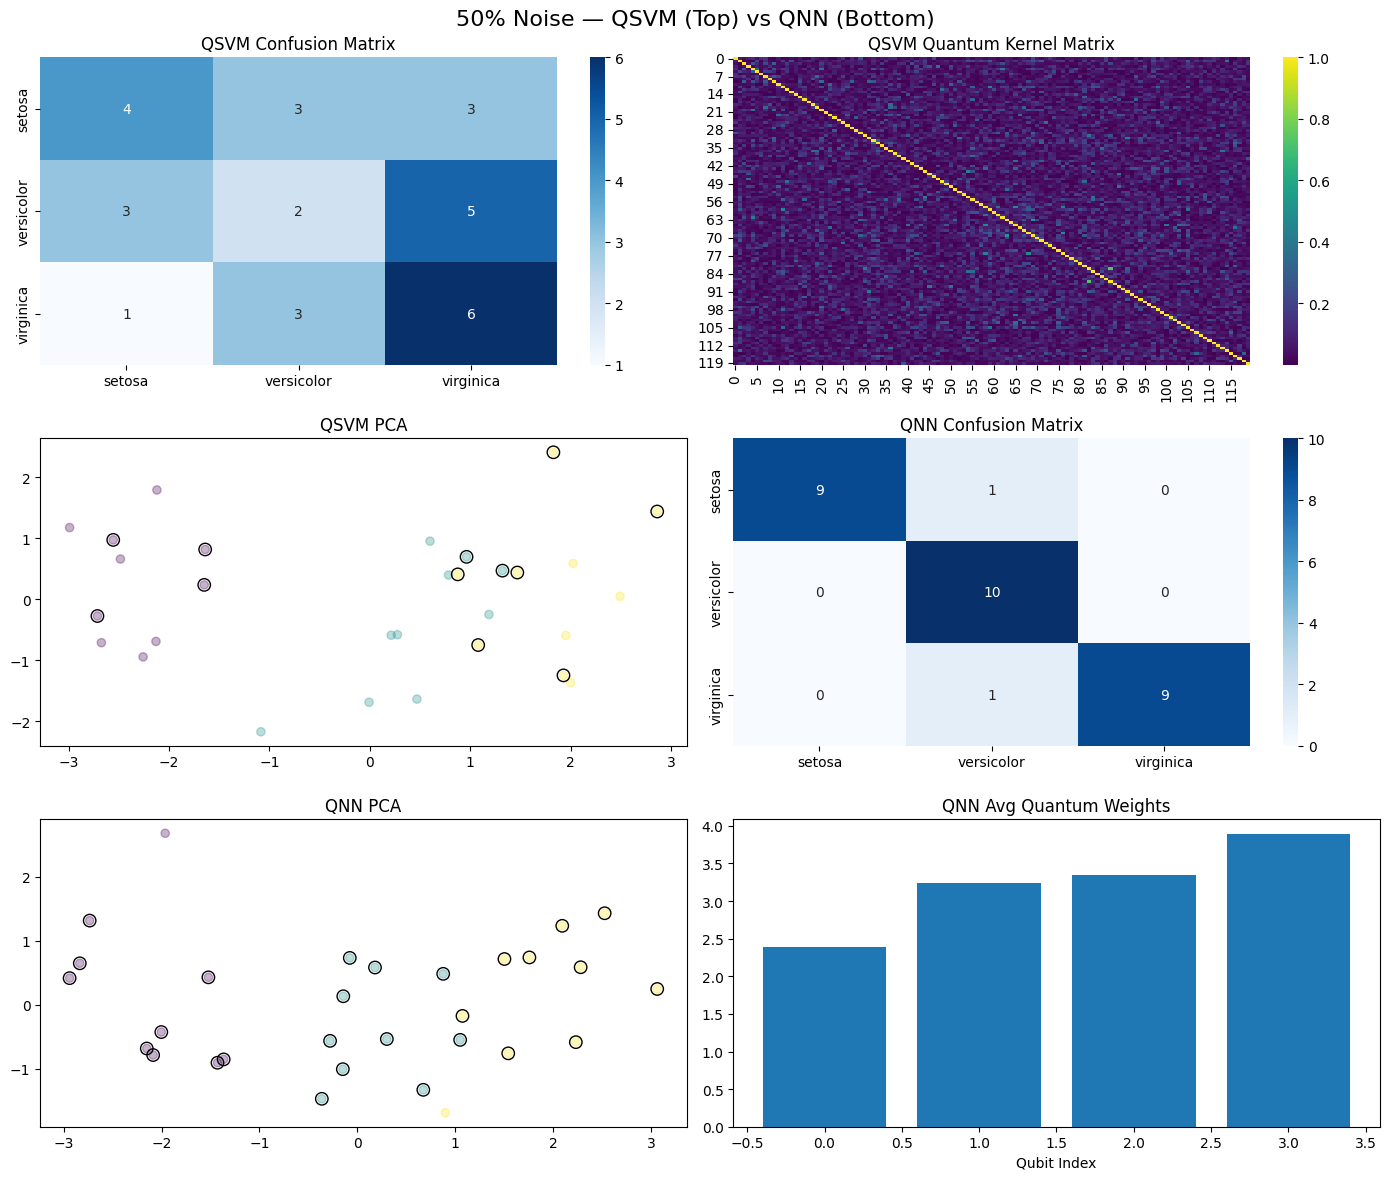

Processing 60% noise


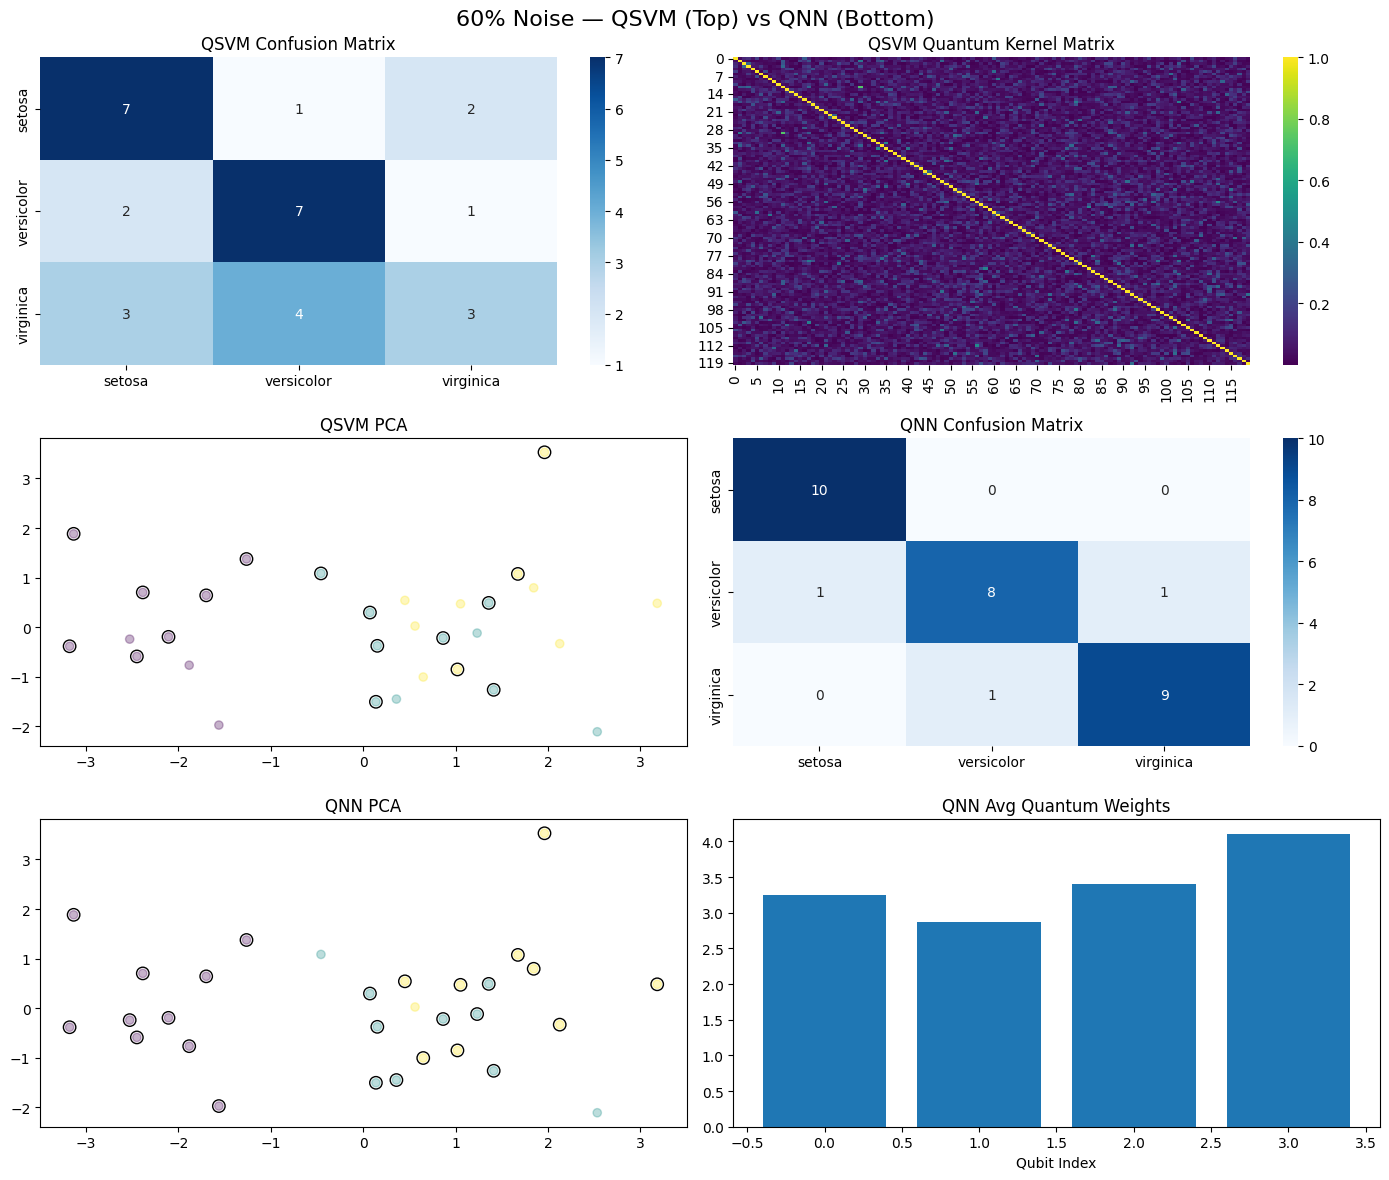

Processing 70% noise


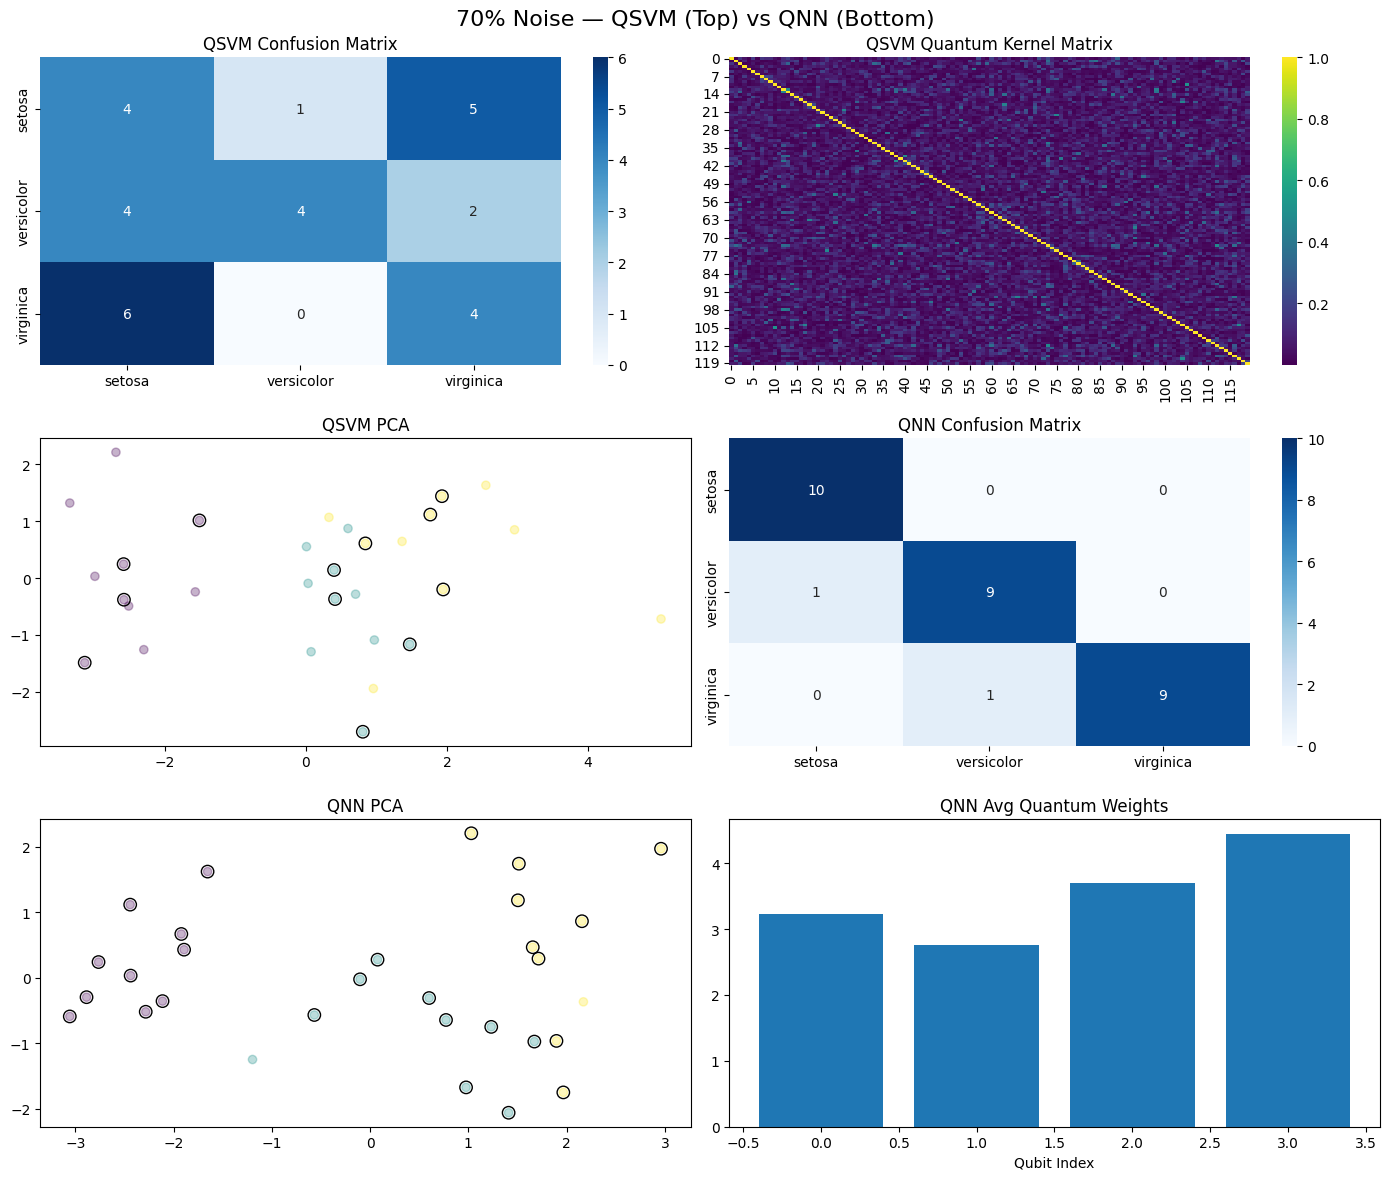

Processing 80% noise


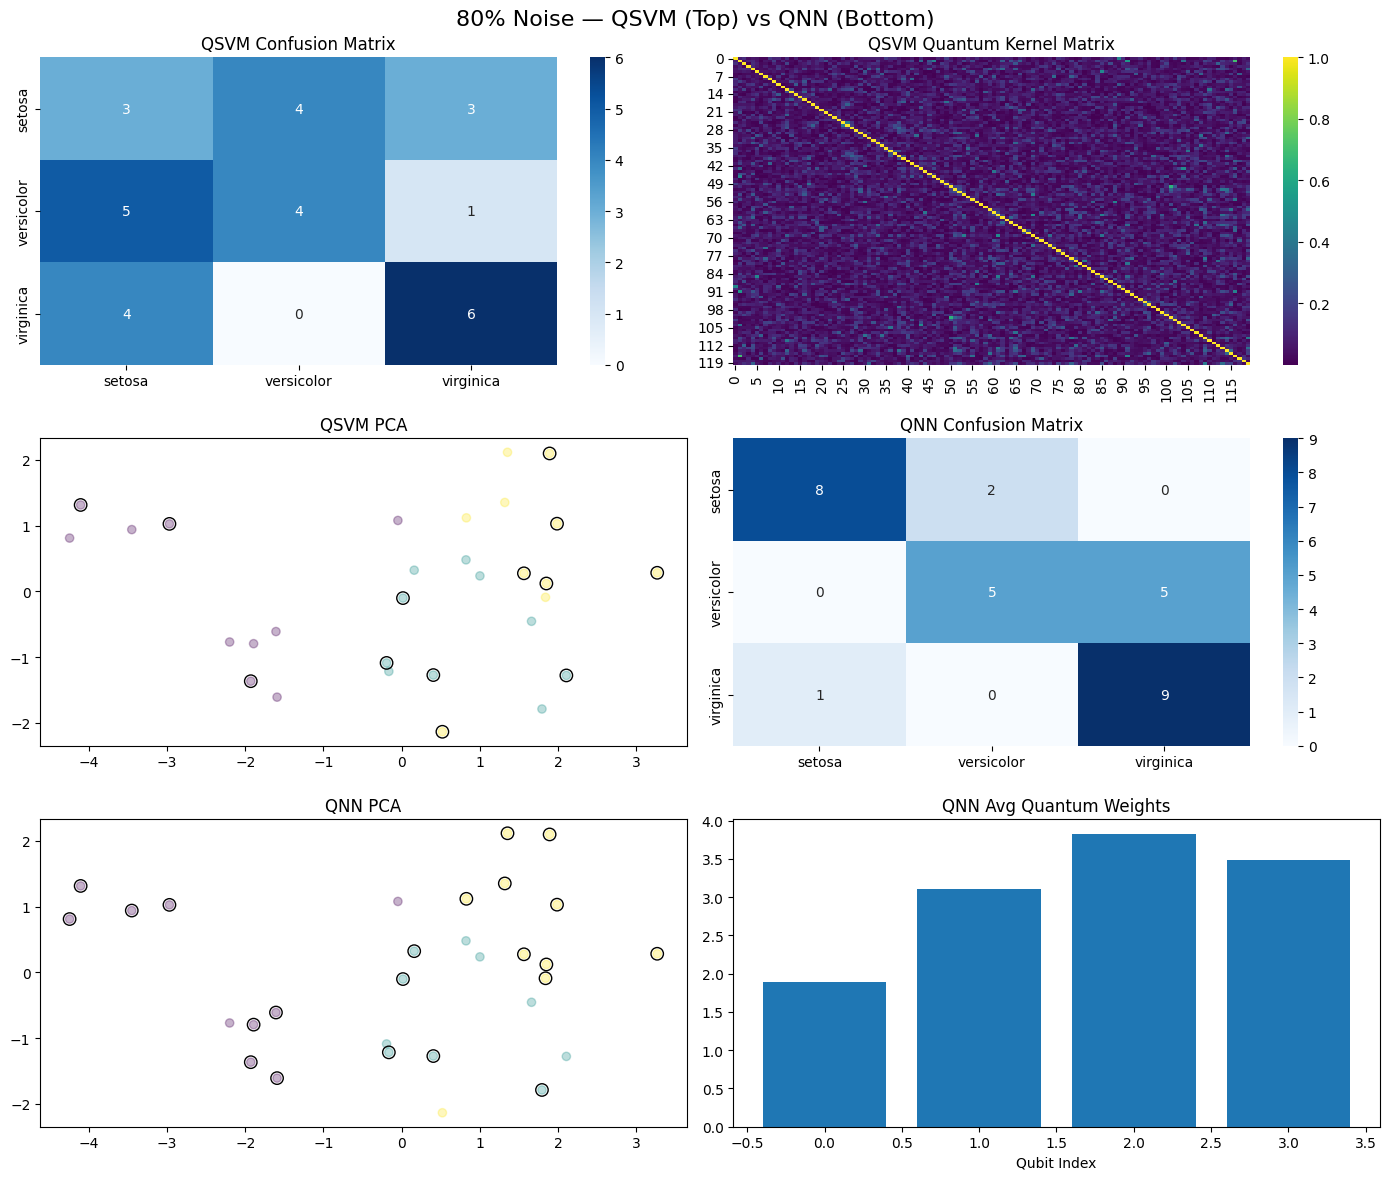

Processing 90% noise


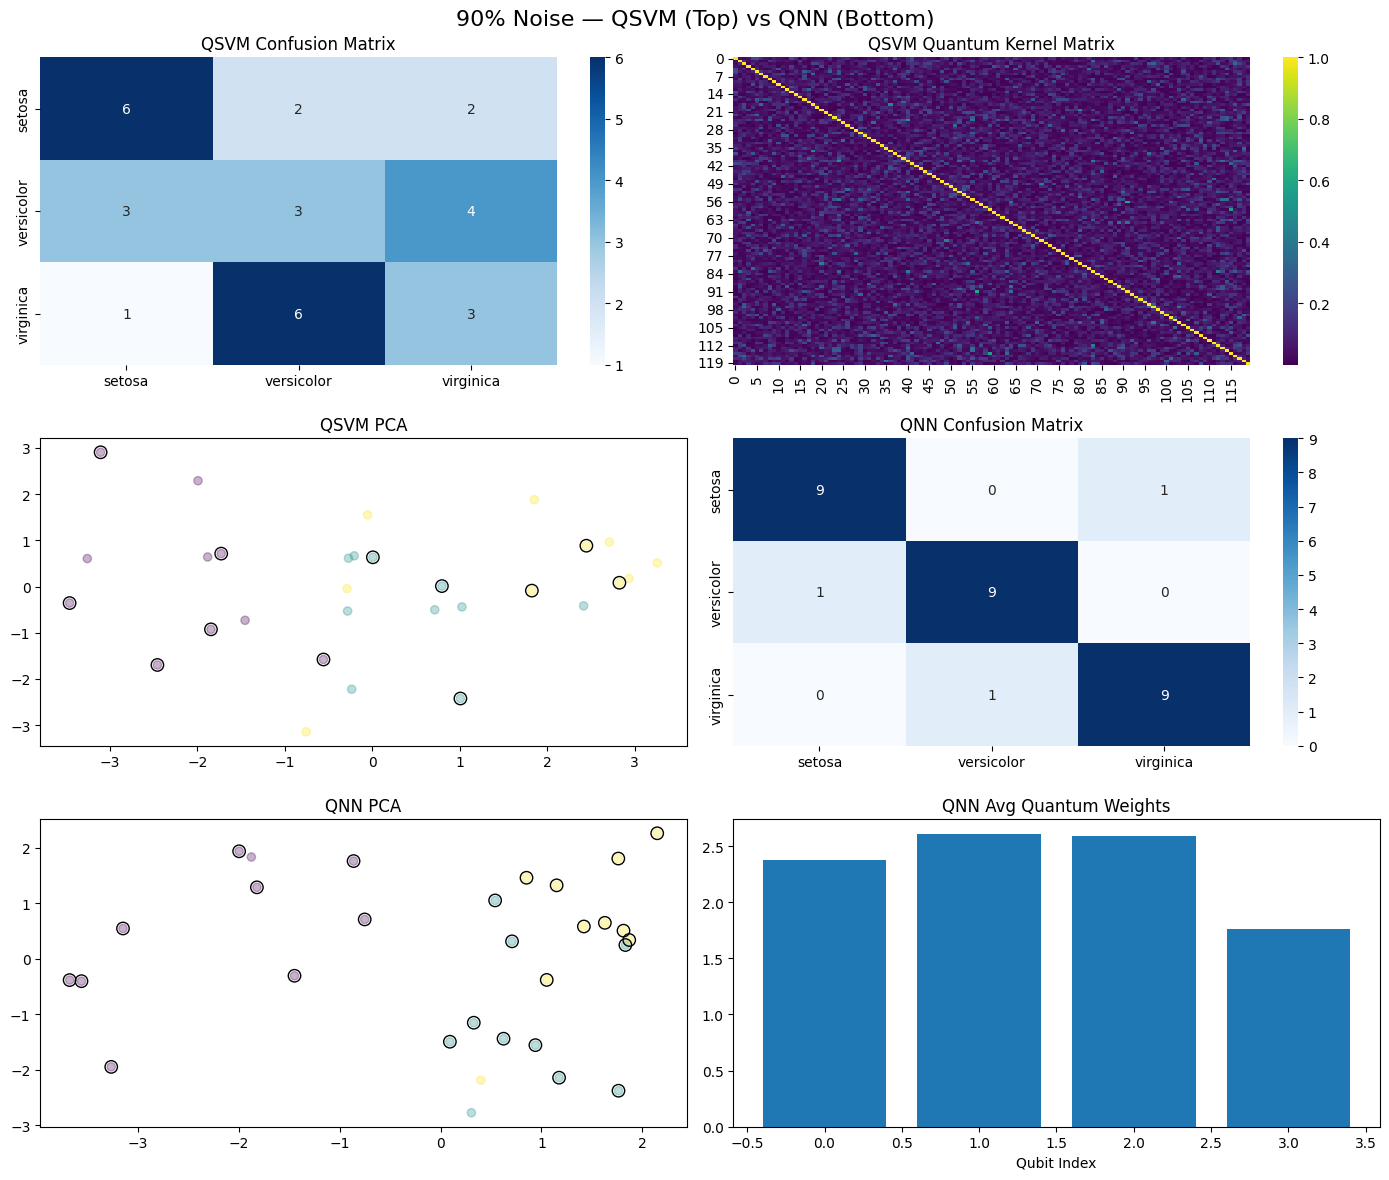

Processing 100% noise


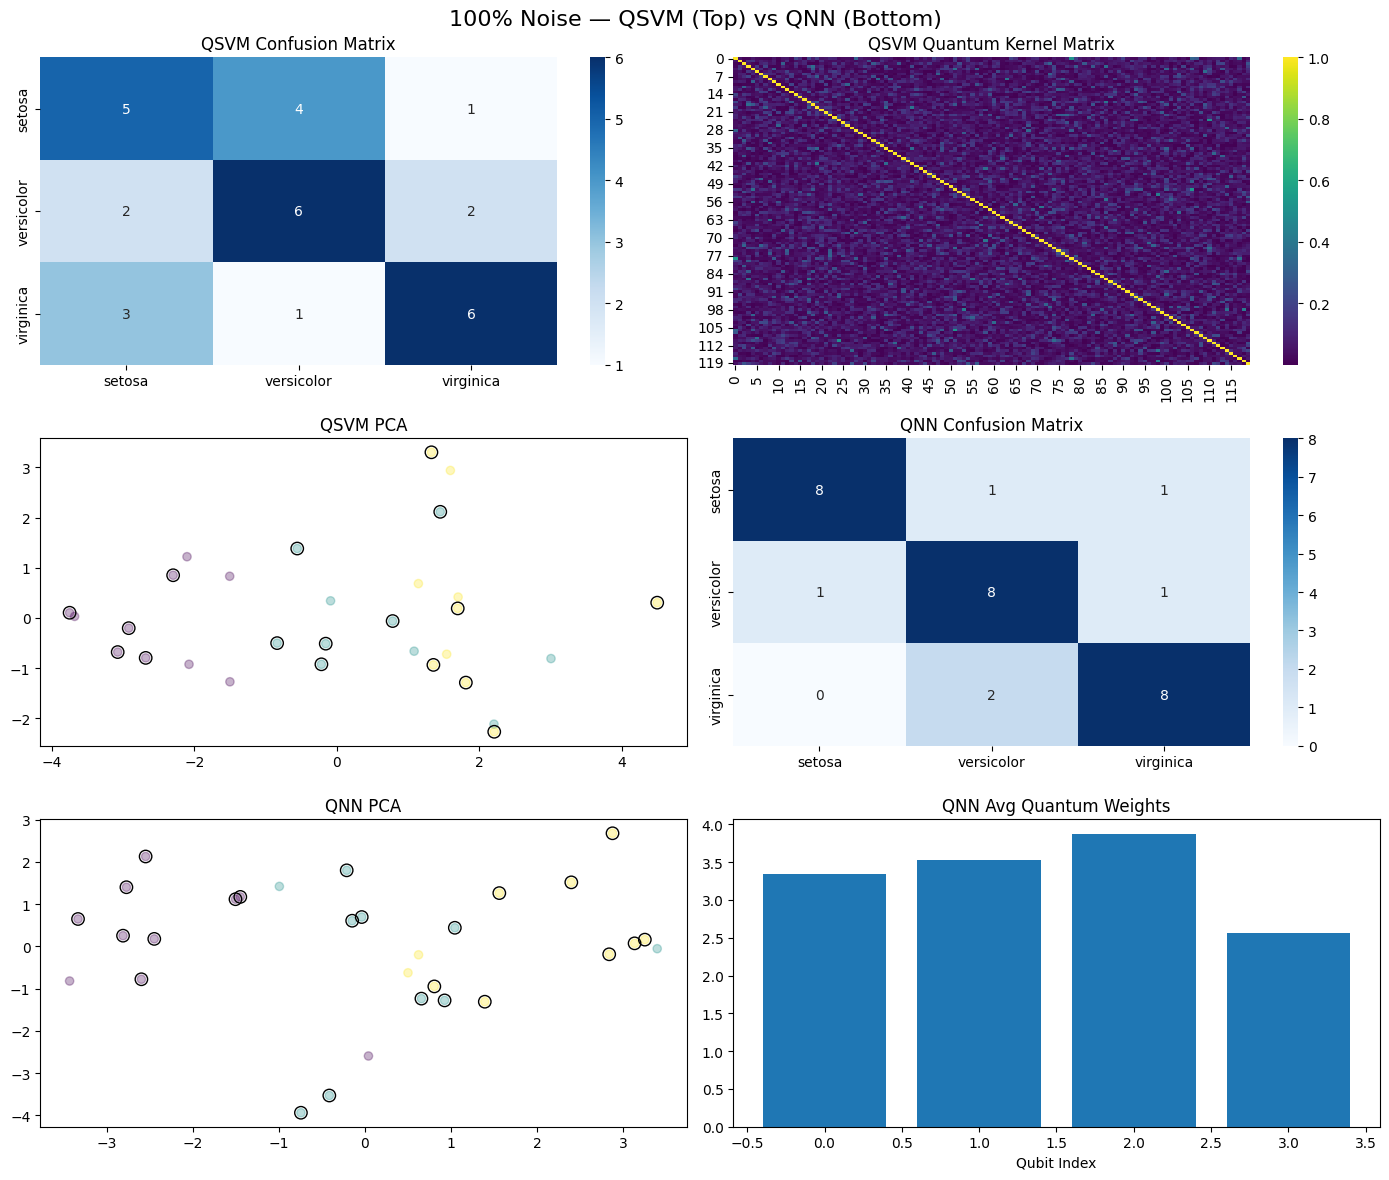

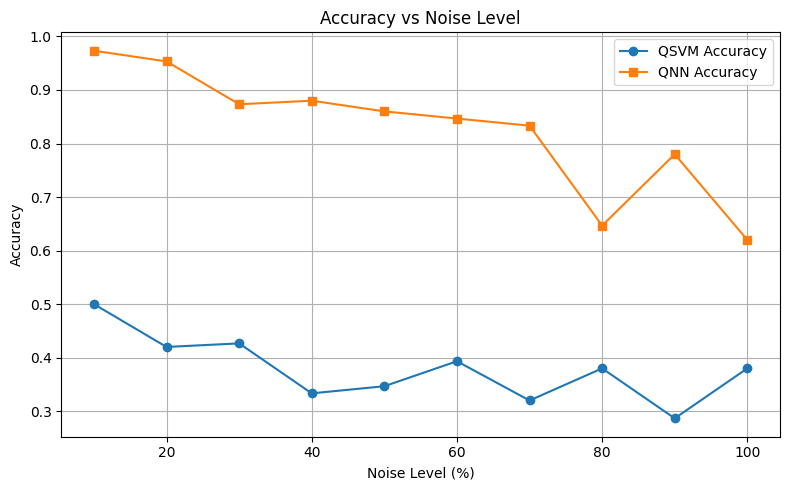

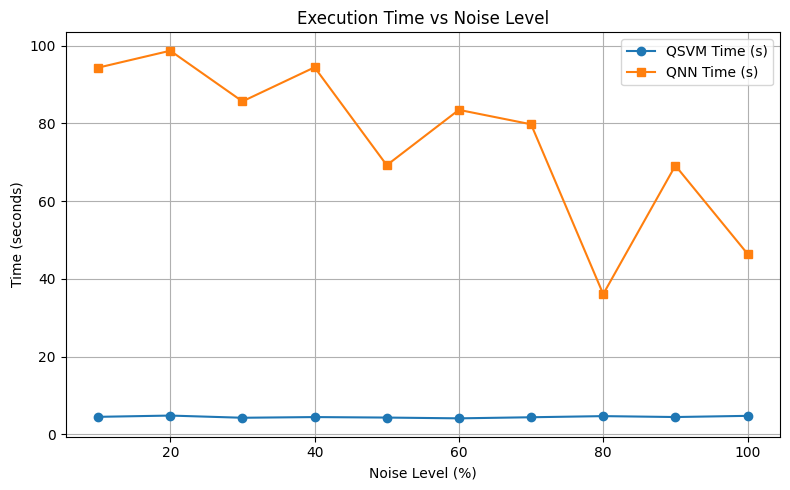

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import pennylane as qml
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel

# Setup
np.random.seed(0)
torch.manual_seed(0)
noise_levels = np.arange(0.1, 1.1, 0.1)
iris = load_iris()
X_base = StandardScaler().fit_transform(iris.data)
y = iris.target
target_names = iris.target_names

# QNN setup
n_qubits = 4
qml_dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(qml_dev, interface="torch")
def qnn_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QNNLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_layer = qml.qnn.TorchLayer(qnn_circuit, {"weights": (3, n_qubits, 3)})

    def forward(self, x):
        return self.q_layer(x)

class HybridQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qnn = QNNLayer()
        self.fc = nn.Linear(n_qubits, 3)

    def forward(self, x):
        return self.fc(self.qnn(x))

class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.best_model = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# QSVM setup
feature_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement="full")
quantum_instance = QuantumInstance(BasicAer.get_backend("statevector_simulator"), shots=1024, seed_simulator=42)

qnn_accs, qsvm_accs = [], []
qnn_times, qsvm_times = [], []

for noise_factor in noise_levels:
    print(f"Processing {int(noise_factor * 100)}% noise")
    X = X_base + np.random.normal(0, noise_factor * X_base.std(), X_base.shape)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # === QSVM ===
    start_qsvm = time.time()
    accs_qsvm = []
    best_cm_qsvm = None
    best_X_qsvm, best_pred_qsvm, best_true_qsvm, best_kernel = None, None, None, None

    for train_idx, test_idx in skf.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)
        kernel_matrix = qkernel.evaluate(x_vec=X_train)
        svc = SVC(kernel=qkernel.evaluate)
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accs_qsvm.append(acc)
        if acc == max(accs_qsvm):
            best_cm_qsvm = confusion_matrix(y_test, y_pred)
            best_X_qsvm = X_test
            best_pred_qsvm = y_pred
            best_true_qsvm = y_test
            best_kernel = kernel_matrix
    qsvm_accs.append(np.mean(accs_qsvm))
    qsvm_times.append(time.time() - start_qsvm)

    # === QNN ===
    start_qnn = time.time()
    accs_qnn = []
    best_cm_qnn = None
    best_X_qnn, best_pred_qnn, best_true_qnn, best_weights = None, None, None, None

    for train_idx, test_idx in skf.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        model = HybridQNN()
        train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                torch.tensor(y_train, dtype=torch.long)),
                                  batch_size=16, shuffle=True)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()
        early_stopper = EarlyStopping(patience=10)

        for epoch in range(100):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = model(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
            model.eval()
            with torch.no_grad():
                val_tensor = torch.tensor(X_test, dtype=torch.float32)
                val_loss = criterion(model(val_tensor), torch.tensor(y_test, dtype=torch.long)).item()

            early_stopper(val_loss, model)
            if early_stopper.early_stop:
                break

        model.load_state_dict(early_stopper.best_model)
        model.eval()
        with torch.no_grad():
            preds = model(torch.tensor(X_test, dtype=torch.float32)).argmax(1).numpy()
        acc = accuracy_score(y_test, preds)
        accs_qnn.append(acc)
        if acc == max(accs_qnn):
            best_cm_qnn = confusion_matrix(y_test, preds)
            best_X_qnn = X_test
            best_pred_qnn = preds
            best_true_qnn = y_test
            best_weights = dict(model.qnn.q_layer.named_parameters())['weights'].detach().numpy()

    qnn_accs.append(np.mean(accs_qnn))
    qnn_times.append(time.time() - start_qnn)

    # === Plot Results ===
    fig, axs = plt.subplots(3, 2, figsize=(14, 12))
    fig.suptitle(f"{int(noise_factor*100)}% Noise — QSVM (Top) vs QNN (Bottom)", fontsize=16)

    sns.heatmap(best_cm_qsvm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names, ax=axs[0, 0])
    axs[0, 0].set_title("QSVM Confusion Matrix")

    sns.heatmap(best_kernel, cmap='viridis', ax=axs[0, 1])
    axs[0, 1].set_title("QSVM Quantum Kernel Matrix")

    pca_qsvm = PCA(n_components=2).fit_transform(best_X_qsvm)
    correct_qsvm = best_pred_qsvm == best_true_qsvm
    axs[1, 0].scatter(pca_qsvm[:, 0], pca_qsvm[:, 1], c=best_true_qsvm, cmap="viridis", alpha=0.3)
    axs[1, 0].scatter(pca_qsvm[correct_qsvm, 0], pca_qsvm[correct_qsvm, 1],
                      edgecolors='black', facecolors='none', s=80)
    axs[1, 0].set_title("QSVM PCA")

    sns.heatmap(best_cm_qnn, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names, ax=axs[1, 1])
    axs[1, 1].set_title("QNN Confusion Matrix")

    pca_qnn = PCA(n_components=2).fit_transform(best_X_qnn)
    correct_qnn = best_pred_qnn == best_true_qnn
    axs[2, 0].scatter(pca_qnn[:, 0], pca_qnn[:, 1], c=best_true_qnn, cmap="viridis", alpha=0.3)
    axs[2, 0].scatter(pca_qnn[correct_qnn, 0], pca_qnn[correct_qnn, 1],
                      edgecolors='black', facecolors='none', s=80)
    axs[2, 0].set_title("QNN PCA")

    avg_weights = best_weights.mean(axis=(0, 2))
    axs[2, 1].bar(np.arange(len(avg_weights)), avg_weights)
    axs[2, 1].set_title("QNN Avg Quantum Weights")
    axs[2, 1].set_xlabel("Qubit Index")

    plt.tight_layout()
    plt.show()

# === Final Accuracy Plot ===
plt.figure(figsize=(8, 5))
plt.plot(noise_levels * 100, qsvm_accs, marker='o', label="QSVM Accuracy")
plt.plot(noise_levels * 100, qnn_accs, marker='s', label="QNN Accuracy")
plt.title("Accuracy vs Noise Level")
plt.xlabel("Noise Level (%)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Final Time Plot ===
plt.figure(figsize=(8, 5))
plt.plot(noise_levels * 100, qsvm_times, marker='o', label="QSVM Time (s)")
plt.plot(noise_levels * 100, qnn_times, marker='s', label="QNN Time (s)")
plt.title("Execution Time vs Noise Level")
plt.xlabel("Noise Level (%)")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
